<section style="font-family: system-ui, -apple-system, Segoe UI, Arial, sans-serif; line-height: 1.5; max-width: 1000px; background-color: #fcfcfc; border: 1px solid #e0e0e0; border-radius: 12px; padding: 25px; box-shadow: 0 4px 16px rgba(0,0,0,0.05);">

  <h1 style="margin: 0 0 10px; font-size: 26px; color: #222;">📊 Working with the PBE/HSE Merged CSV</h1>
  <p style="margin: 0 0 20px; color: #555;">
    This dataset stores each configuration's <b>pymatgen Structure as JSON</b>, along with scalar fields like
    <code>Energy</code>, <code>Forces</code>, and text metadata.
    Use the recipes below to reconstruct structures, export files, and analyze data.
  </p>

  <h2 style="margin: 24px 0 8px; font-size: 19px; color: #333; border-bottom: 1px solid #eee; padding-bottom: 6px;">📥 1) Quick load (from GitHub Releases)</h2>
  <pre style="background: #f6f8fa; color: #24292e; padding: 14px; border: 1px solid #eaeaea; border-radius: 8px; overflow: auto; font-size: 14px;">
<span style="color:#d73a49;">import</span> pandas <span style="color:#d73a49;">as</span> pd

CSV_URL = <span style="color:#032f62;">"https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_p1.csv/pbe_merged_data_p1.csv"</span>
CSV_URL = <span style="color:#032f62;">"https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_p1.csv/pbe_merged_data_p1.csv"</span>
df = pd.read_csv(CSV_URL)
<span style="color:#005cc5;">print</span>(df.head())
  </pre>

  <details style="margin: 12px 0; border: 1px solid #e0e0e0; border-radius: 8px; padding: 12px; background: #fafbfc;">
    <summary style="cursor: pointer; font-weight: 600; color: #005cc5;">💾 Optional: Cache locally in your HOME directory</summary>
    <pre style="background: #f6f8fa; color: #24292e; padding: 14px; border: 1px solid #eaeaea; border-radius: 8px; overflow: auto; font-size: 14px; margin-top: 10px;">
<span style="color:#d73a49;">from</span> pathlib <span style="color:#d73a49;">import</span> Path
<span style="color:#d73a49;">import</span> requests

<span style="color:#d73a49;">def</span> <span style="color:#6f42c1;">load_or_cache_csv</span>(url: <span style="color:#005cc5;">str</span>, local_name: <span style="color:#005cc5;">str</span>, folder=<span style="color:#032f62;">"datasets"</span>):
    local_dir = Path.home() / folder
    local_dir.mkdir(parents=<span style="color:#005cc5;">True</span>, exist_ok=<span style="color:#005cc5;">True</span>)
    local_path = local_dir / local_name
    <span style="color:#d73a49;">if not</span> local_path.exists():
        r = requests.get(url, timeout=<span style="color:#005cc5;">60</span>)
        r.raise_for_status()
        local_path.write_bytes(r.content)
        <span style="color:#005cc5;">print</span>(<span style="color:#032f62;">f"⬇️  Downloaded to </span>{local_path}<span style="color:#032f62;">"</span>)
    <span style="color:#d73a49;">else</span>:
        <span style="color:#005cc5;">print</span>(<span style="color:#032f62;">f"📂 Using cached file: </span>{local_path}<span style="color:#032f62;">"</span>)
    <span style="color:#d73a49;">return</span> pd.read_csv(local_path)

df = load_or_cache_csv(CSV_URL, <span style="color:#032f62;">"pbe_merged_data_p1.csv"</span>)
    </pre>
  </details>

  <h2 style="margin: 24px 0 8px; font-size: 19px; color: #333; border-bottom: 1px solid #eee; padding-bottom: 6px;">📋 2) Column descriptions</h2>
  <ul style="margin: 0 0 10px 20px; color: #444;">
    <li><b>Structure</b>: JSON string for a <code>pymatgen.core.structure.Structure</code>.</li>
    <li><b>Energy</b>: Total energy for the configuration (typically eV).</li>
    <li><b>Forces</b>: JSON string of a list with shape <code>N×3</code>.</li>
    <li><b>Stress</b>: JSON string of a list with shape <code>3×3</code>.</li>
    <li><b>Directory</b>: Path-like string describing the system; useful for parsing labels.</li>
    <li><b>Tag</b>: Category label (e.g., <code>defect</code>, <code>interface</code>, etc.).</li>
    <li style="color: #888;"><i>Other columns like <code>Frequency</code> or <code>CFE</code> may be dataset-specific.</i></li>
  </ul>

  <h2 style="margin: 24px 0 8px; font-size: 19px; color: #333; border-bottom: 1px solid #eee; padding-bottom: 6px;">🏗️ 3) Reconstruct a Structure and export files</h2>
  <pre style="background: #f6f8fa; color: #24292e; padding: 14px; border: 1px solid #eaeaea; border-radius: 8px; overflow: auto; font-size: 14px;">
<span style="color:#d73a49;">import</span> json
<span style="color:#d73a49;">from</span> pathlib <span style="color:#d73a49;">import</span> Path
<span style="color:#d73a49;">from</span> pymatgen.core <span style="color:#d73a49;">import</span> Structure
<span style="color:#d73a49;">from</span> pymatgen.io.vasp <span style="color:#d73a49;">import</span> Poscar
<span style="color:#d73a49;">from</span> pymatgen.io.cif <span style="color:#d73a49;">import</span> CifWriter

row = df.iloc[<span style="color:#005cc5;">0</span>]  <span style="color:#6a737d;"># Example: first row</span>
s_dict = json.loads(row[<span style="color:#032f62;">"Structure"</span>])
pmg_struct = Structure.from_dict(s_dict)

<span style="color:#005cc5;">print</span>(<span style="color:#032f62;">"Formula:"</span>, pmg_struct.composition.reduced_formula)

<span style="color:#6a737d;"># Save files to a dedicated folder in your home directory</span>
out_dir = Path.home() / <span style="color:#032f62;">"pbe_csv_exports"</span>
out_dir.mkdir(parents=<span style="color:#005cc5;">True</span>, exist_ok=<span style="color:#005cc5;">True</span>)
Poscar(pmg_struct).write_file(out_dir / <span style="color:#032f62;">"example_POSCAR.vasp"</span>)
CifWriter(pmg_struct).write_file(out_dir / <span style="color:#032f62;">"example_structure.cif"</span>)
<span style="color:#005cc5;">print</span>(<span style="color:#032f62;">"Files saved to:"</span>, out_dir)
  </pre>

  <h2 style="margin: 24px 0 8px; font-size: 19px; color: #333; border-bottom: 1px solid #eee; padding-bottom: 6px;">🔢 4) Parse Forces and Stress into NumPy arrays</h2>
  <pre style="background: #f6f8fa; color: #24292e; padding: 14px; border: 1px solid #eaeaea; border-radius: 8px; overflow: auto; font-size: 14px;">
<span style="color:#d73a49;">import</span> numpy <span style="color:#d73a49;">as</span> np
<span style="color:#d73a49;">import</span> json

<span style="color:#6a737d;"># Using the same 'row' from the previous example</span>
forces = np.array(json.loads(row[<span style="color:#032f62;">"Forces"</span>]))   <span style="color:#6a737d;"># shape (N, 3)</span>
stress = np.array(json.loads(row[<span style="color:#032f62;">"Stress"</span>]))   <span style="color:#6a737d;"># shape (3, 3)</span>

<span style="color:#005cc5;">print</span>(<span style="color:#032f62;">f"Forces shape: </span>{forces.shape}<span style="color:#032f62;">"</span>)
<span style="color:#005cc5;">print</span>(<span style="color:#032f62;">f"Stress tensor:\n</span>{stress}<span style="color:#032f62;">"</span>)
  </pre>
  
  <h2 style="margin: 24px 0 8px; font-size: 19px; color: #333; border-bottom: 1px solid #eee; padding-bottom: 6px;">🏷️ 5) Infer defect labels from the Directory string</h2>
  <p style="margin: 0 0 10px; color: #555;">
    Often, the defect name is embedded in the <code>Directory</code>. For a path like <code>..._single_As_Cd_C1_...</code>, we can parse out <code>As_Cd</code>.
  </p>
  <pre style="background: #f6f8fa; color: #24292e; padding: 14px; border: 1px solid #eaeaea; border-radius: 8px; overflow: auto; font-size: 14px;">
<span style="color:#d73a49;">import</span> re

<span style="color:#d73a49;">def</span> <span style="color:#6f42c1;">infer_defect_label</span>(directory: <span style="color:#005cc5;">str</span>) -> <span style="color:#005cc5;">str</span> | <span style="color:#005cc5;">None</span>:
    <span style="color:#6a737d;"># Example regex: grabs token between "single_" and "_C1"</span>
    m = re.search(<span style="color:#032f62;">r"single_([^_]+_[^_]+)_C1"</span>, <span style="color:#005cc5;">str</span>(directory))
    <span style="color:#d73a49;">return</span> m.group(<span style="color:#005cc5;">1</span>) <span style="color:#d73a49;">if</span> m <span style="color:#d73a49;">else</span> <span style="color:#005cc5;">None</span>

df[<span style="color:#032f62;">"defect_label"</span>] = df[<span style="color:#032f62;">"Directory"</span>].apply(infer_defect_label)
<span style="color:#005cc5;">print</span>(df[[<span style="color:#032f62;">"Directory"</span>, <span style="color:#032f62;">"defect_label"</span>]].head())
  </pre>

  <h2 style="margin: 24px 0 8px; font-size: 19px; color: #333; border-bottom: 1px solid #eee; padding-bottom: 6px;">🔍 6) Filter common subsets</h2>
  <pre style="background: #f6f8fa; color: #24292e; padding: 14px; border: 1px solid #eaeaea; border-radius: 8px; overflow: auto; font-size: 14px;">
<span style="color:#6a737d;"># Get all rows tagged as 'defect'</span>
df_def = df[df[<span style="color:#032f62;">"Tag"</span>] == <span style="color:#032f62;">"defect"</span>]

<span style="color:#6a737d;"># Keep only rows where a label was successfully inferred</span>
df_labeled = df_def.dropna(subset=[<span style="color:#032f62;">'defect_label'</span>])

<span style="color:#6a737d;"># Example: find all 'As_Te' substitutions</span>
df_As_Te = df_labeled[df_labeled[<span style="color:#032f62;">"defect_label"</span>] == <span style="color:#032f62;">"As_Te"</span>]
<span style="color:#005cc5;">print</span>(<span style="color:#032f62;">f"Found </span>{<span style="color:#005cc5;">len</span>(df_As_Te)}<span style="color:#032f62;"> rows for As_Te defects."</span>)
  </pre>

  <h2 style="margin: 24px 0 8px; font-size: 19px; color: #333; border-bottom: 1px solid #eee; padding-bottom: 6px;">🔄 7) Switch to other charge-state CSVs</h2>
  <p style="margin: 0 0 10px; color: #555;">
    Your repository may have parallel CSVs for different charge states. Simply change the filename in the URL to load them.
  </p>
  <pre style="background: #f6f8fa; color: #24292e; padding: 14px; border: 1px solid #eaeaea; border-radius: 8px; overflow: auto; font-size: 14px;">
BASE_URL = <span style="color:#032f62;">"https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/{f}/{f}"</span>
CSV_FILE = <span style="color:#032f62;">"pbe_merged_data_m1.csv"</span>  <span style="color:#6a737d;"># Change to m2, p2, neutral, etc.</span>
NEW_URL  = BASE_URL.format(f=CSV_FILE)

<span style="color:#6a737d;"># Uses the helper function from section 1</span>
df_m1 = load_or_cache_csv(NEW_URL, CSV_FILE)
  </pre>

</section>

# Data Access

In [1]:
import pandas as pd

CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_p1.csv/pbe_merged_data_p1.csv"
df = pd.read_csv(CSV_URL)
print(df.head())

                                           Structure      Energy  \
0  {"@module": "pymatgen.core.structure", "@class... -553.731986   
1  {"@module": "pymatgen.core.structure", "@class... -546.156578   
2  {"@module": "pymatgen.core.structure", "@class... -550.402091   
3  {"@module": "pymatgen.core.structure", "@class... -550.426240   
4  {"@module": "pymatgen.core.structure", "@class... -549.130832   

                                              Forces  \
0  [[0.00040239, 0.00603221, 0.00461177], [-0.004...   
1  [[0.01177772, -0.0104059, 0.08709349], [0.2451...   
2  [[-0.00279626, -0.00393431, -0.00435702], [0.0...   
3  [[-0.00209444, -0.00395456, -0.0050472], [0.00...   
4  [[0.00099335, -0.00737989, -0.0285797], [-0.01...   

                                              Stress  \
0  [[0.2005008, 0.01300421, 0.17479053], [0.01300...   
1  [[0.37237578, -0.00626329, -0.12203348], [-0.0...   
2  [[0.94316555, -0.00453021, 0.01576381], [-0.00...   
3  [[0.97410229, -0.01153414, 

In [2]:
import pandas as pd

CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/hse_merged_data_p1.csv/hse_merged_data_p1.csv"
df = pd.read_csv(CSV_URL)
print(df.head())

                                           Structure      Energy  \
0  {"@module": "pymatgen.core.structure", "@class... -437.422795   
1  {"@module": "pymatgen.core.structure", "@class... -437.423163   
2  {"@module": "pymatgen.core.structure", "@class... -437.485605   
3  {"@module": "pymatgen.core.structure", "@class... -437.536369   
4  {"@module": "pymatgen.core.structure", "@class... -437.570323   

                                              Forces  \
0  [[0.0, -0.02224786, -0.01034099], [0.02294701,...   
1  [[-0.01019515, -0.01938858, 0.05206342], [-0.0...   
2  [[-0.00956615, -0.021405, 0.00932216], [-0.006...   
3  [[-0.00822358, -0.02432182, -0.06346051], [-0....   
4  [[-0.00384619, -0.02016665, -0.0484102], [-0.0...   

                                              Stress  \
0  [[-5.2021478, 0.0, 0.0], [0.0, -6.01576789, -0...   
1  [[-4.4899415, -0.00510916, 0.00289119], [-0.00...   
2  [[-4.73273067, -0.0072678, 0.00688972], [-0.00...   
3  [[-4.80576344, 0.00765244, 

# Visualize Data

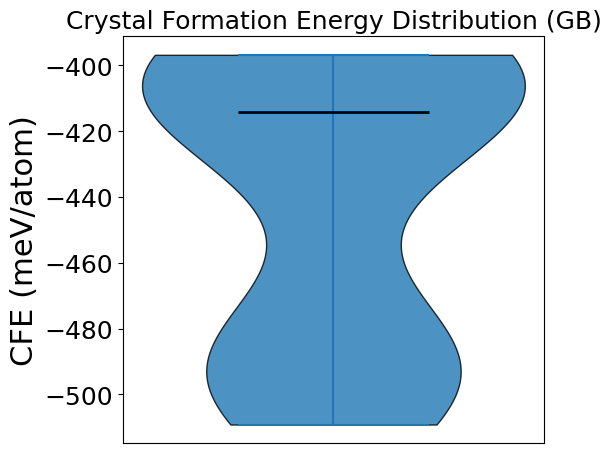

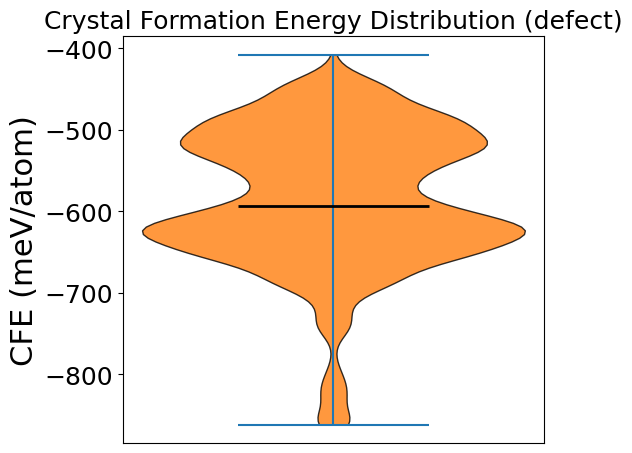

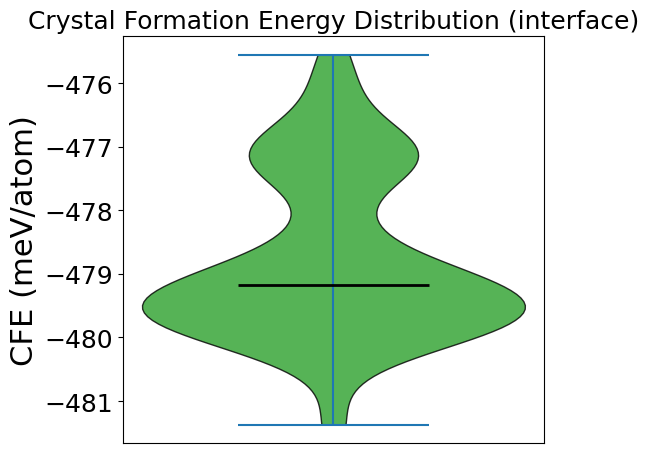

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [3]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_p2.csv/pbe_merged_data_p2.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

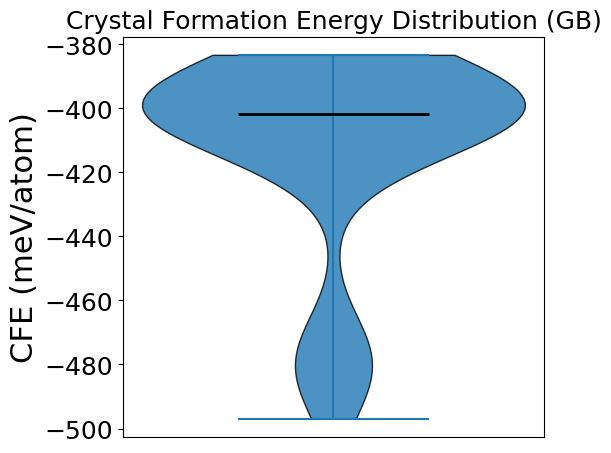

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

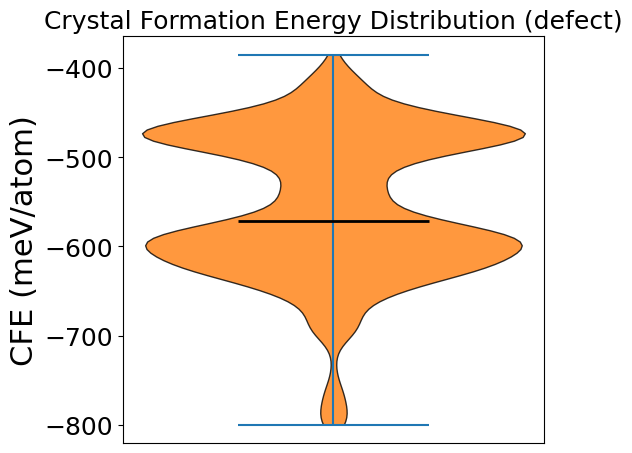

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

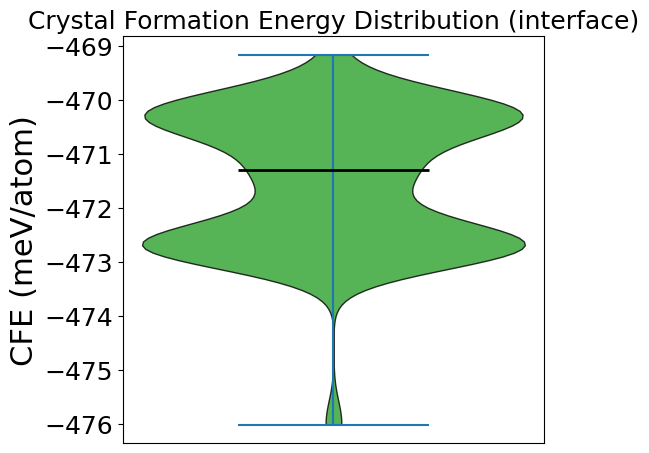

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [44]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_p1.csv/pbe_merged_data_p1.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

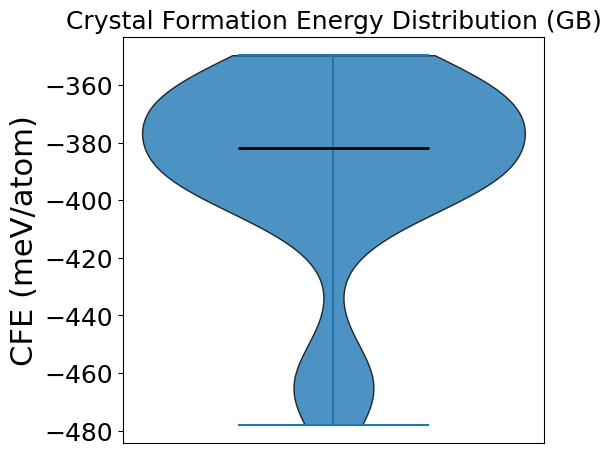

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

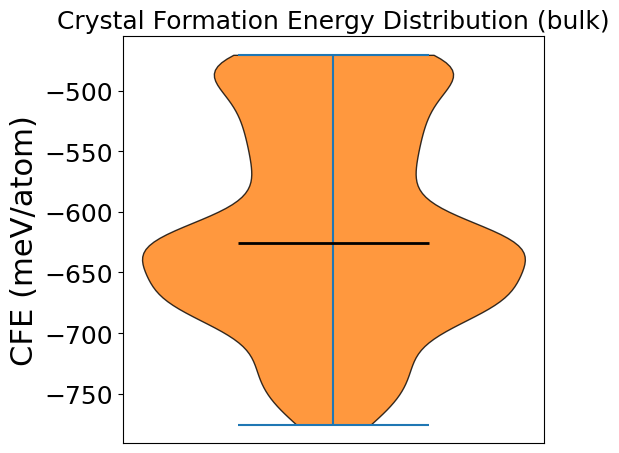

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

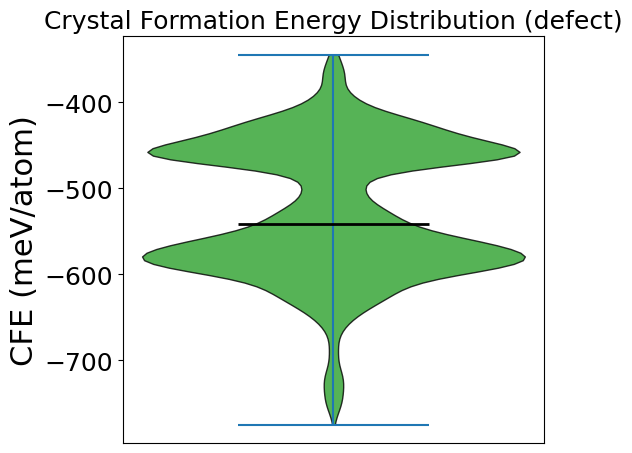

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

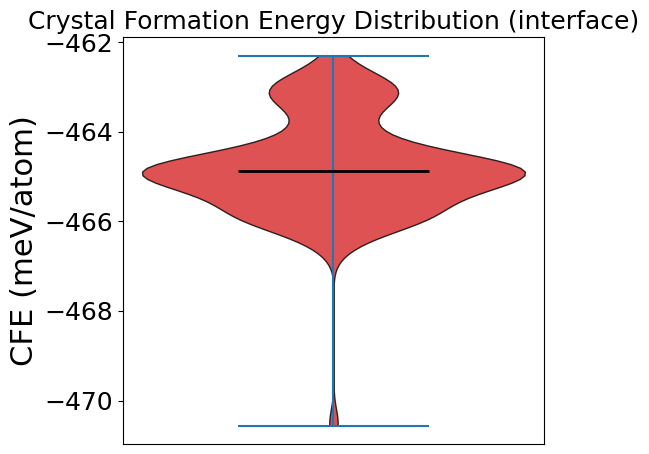

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [49]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_neutral.csv/pbe_merged_data_neutral.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

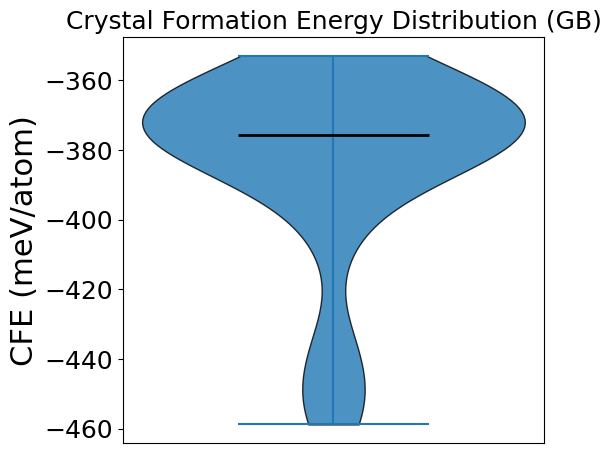

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

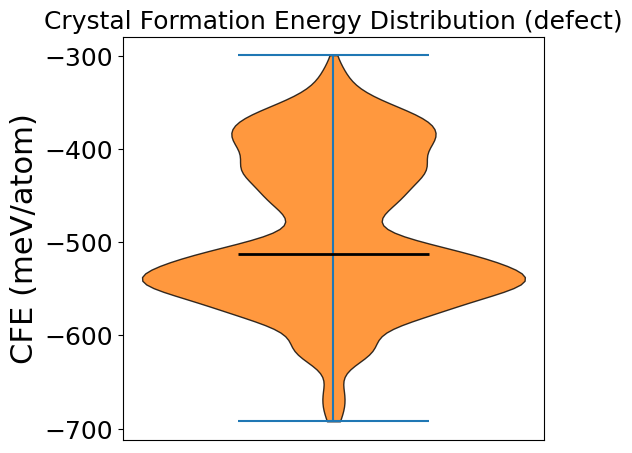

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

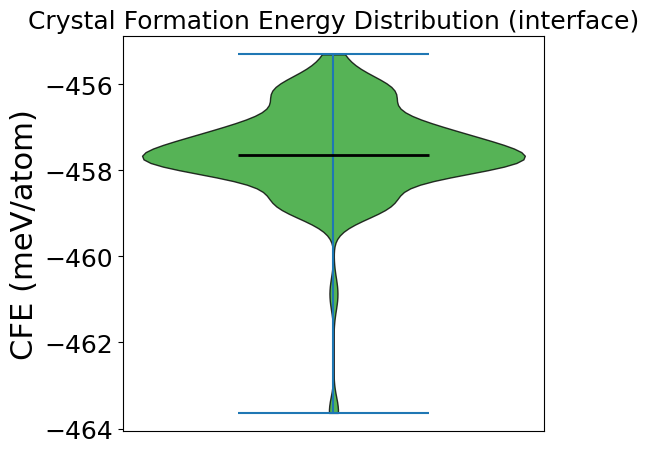

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [50]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_m1.csv/pbe_merged_data_m1.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

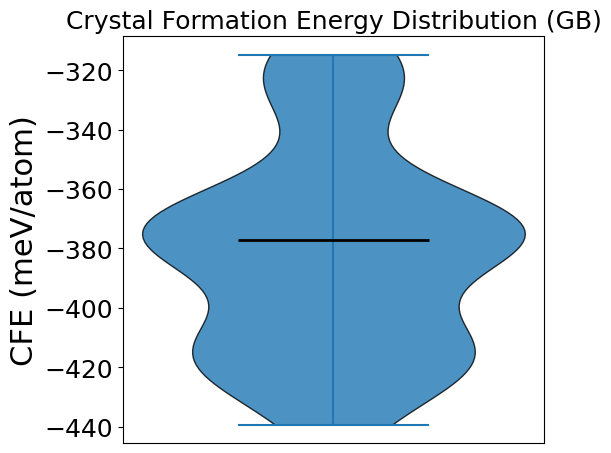

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

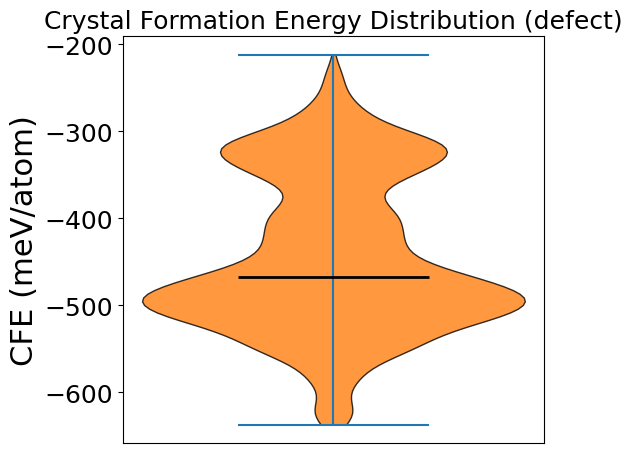

findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

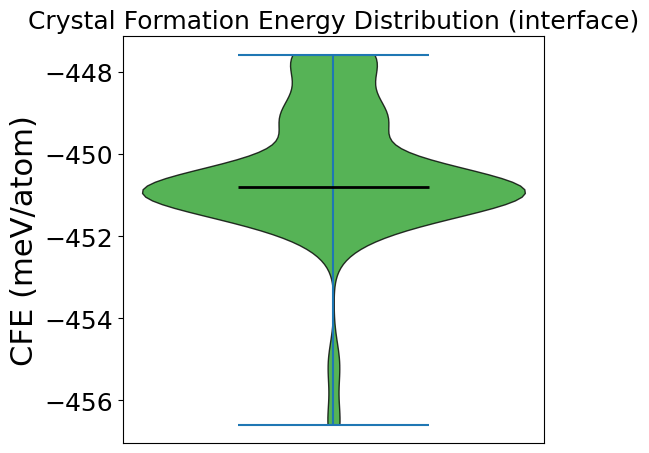

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [51]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_m2.csv/pbe_merged_data_m2.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

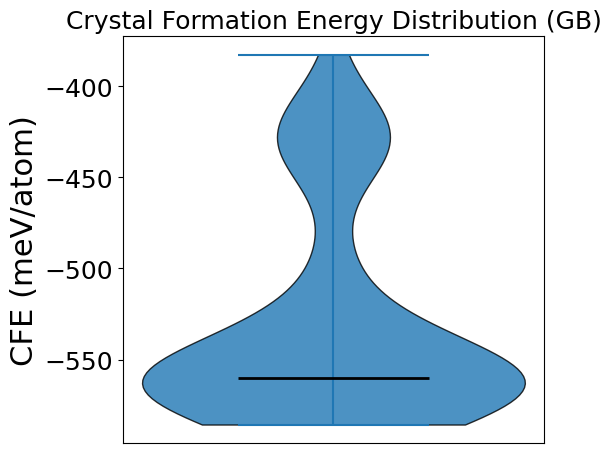

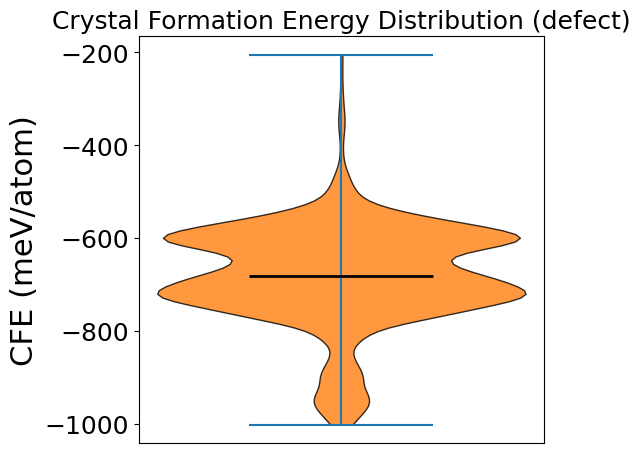

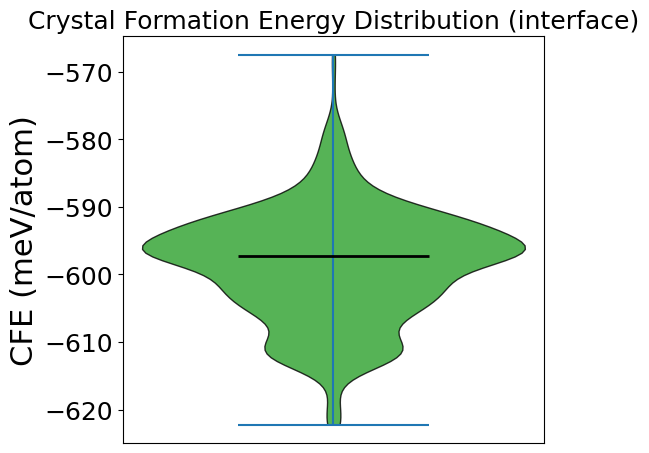

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [3]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/hse_merged_data_p2.csv/hse_merged_data_p2.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

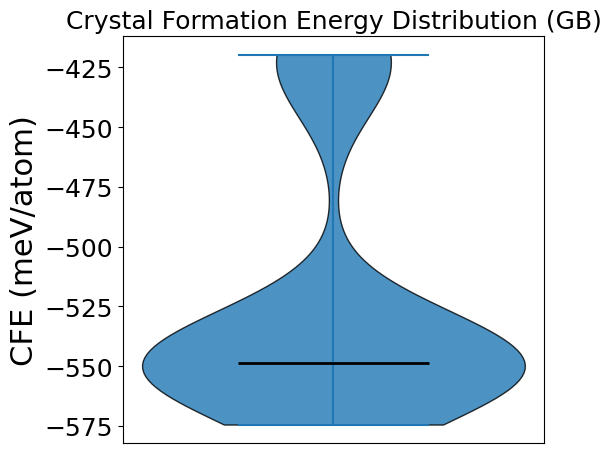

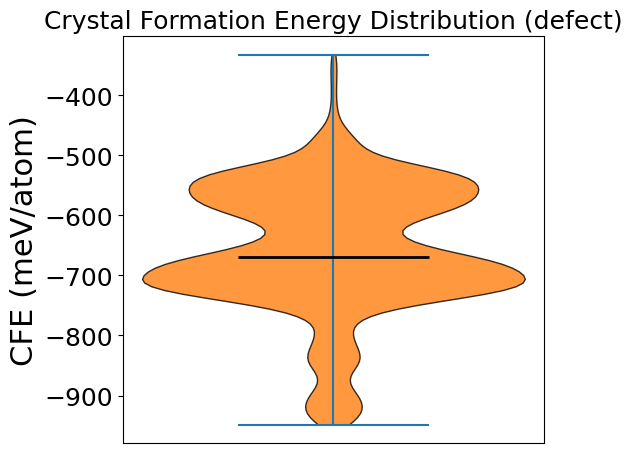

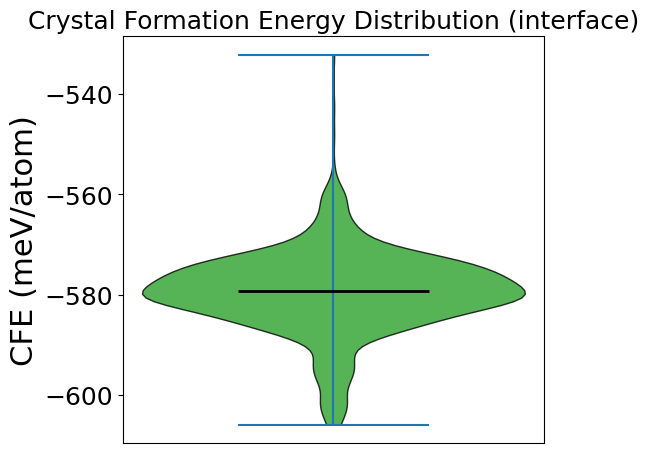

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [4]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/hse_merged_data_p1.csv/hse_merged_data_p1.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

In [ ]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/pbe_merged_data_p2.csv/pbe_merged_data_p2.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

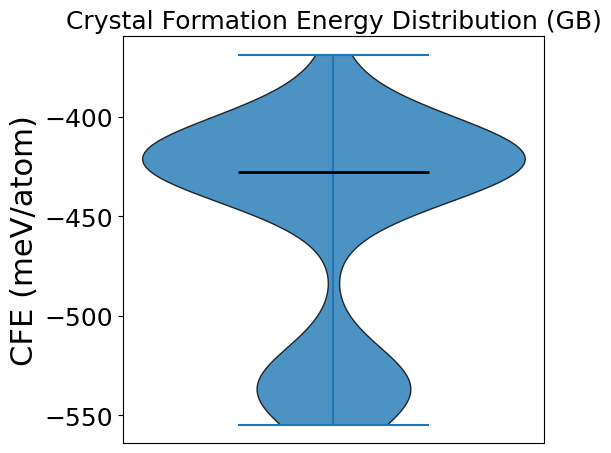

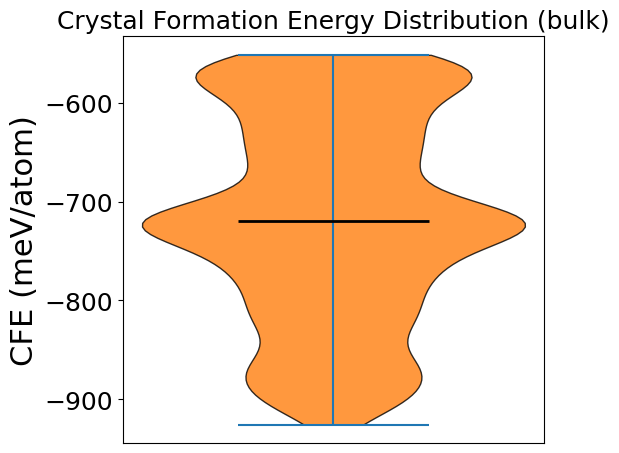

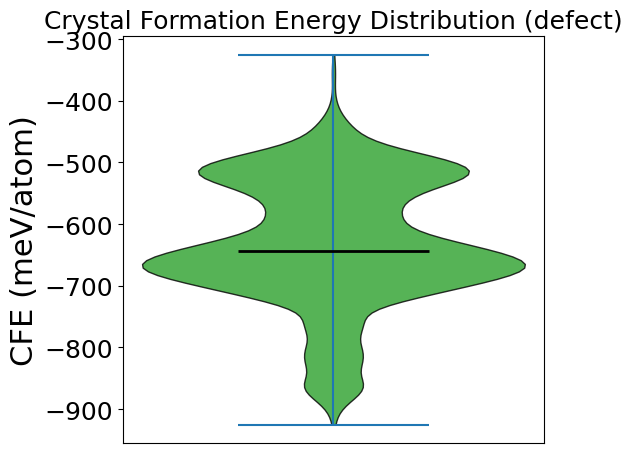

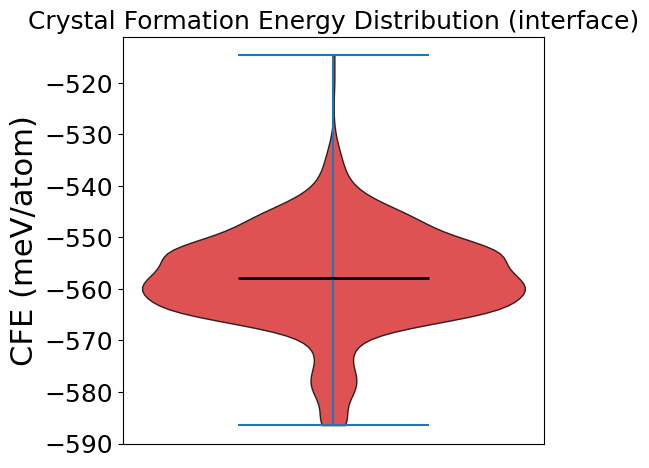

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [5]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/hse_merged_data_neutral.csv/hse_merged_data_neutral.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

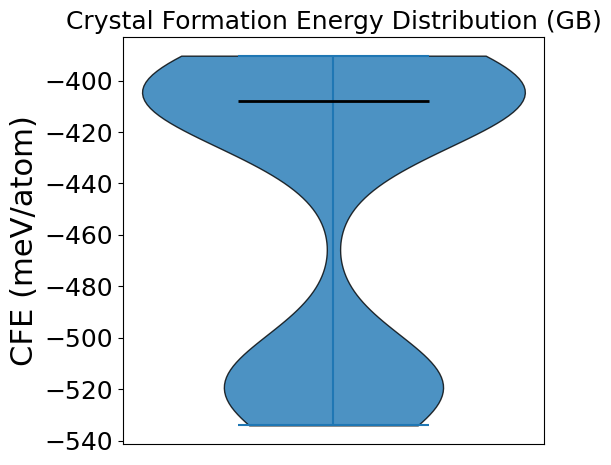

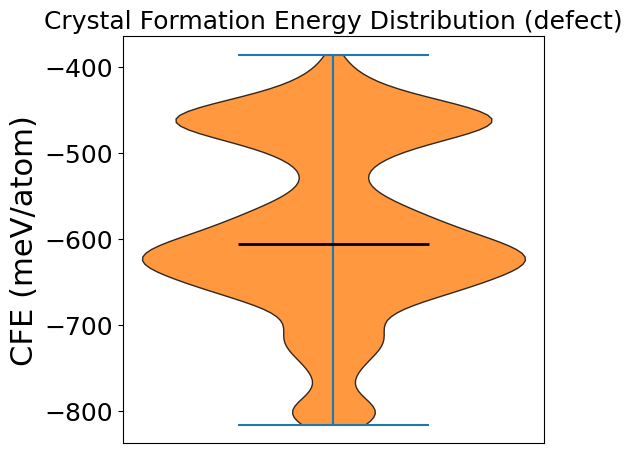

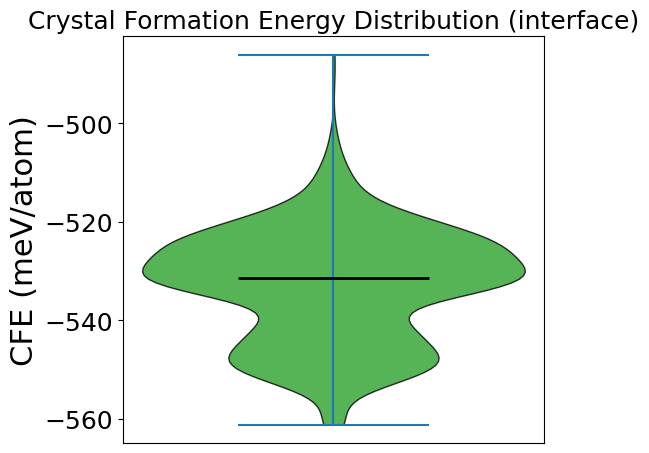

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [6]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/hse_merged_data_m1.csv/hse_merged_data_m1.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

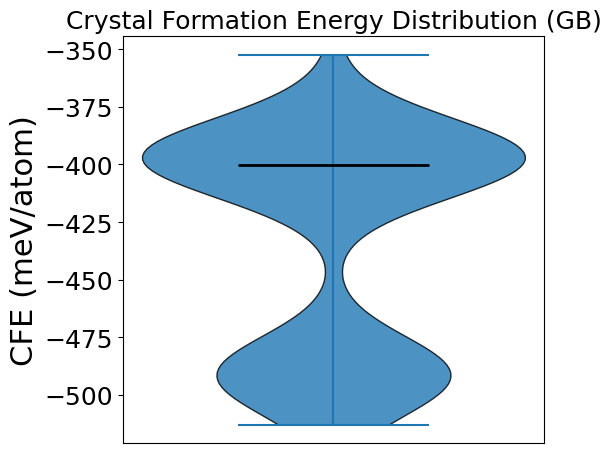

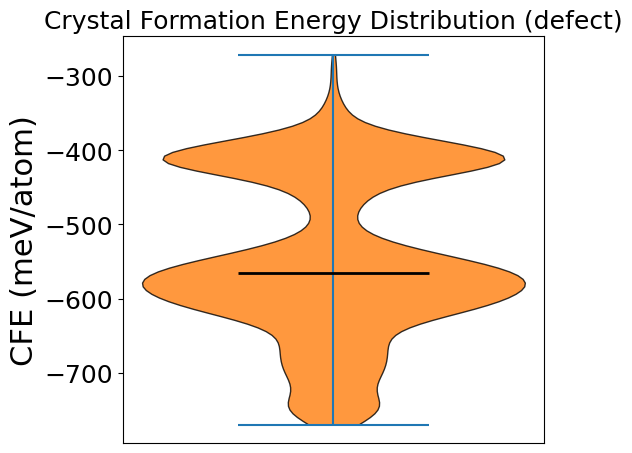

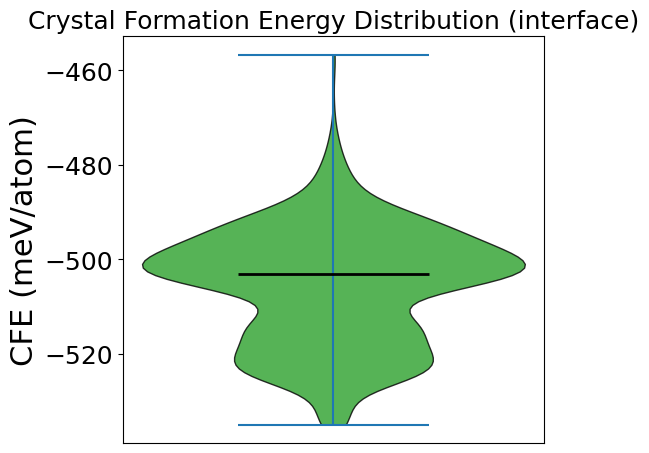

✅ Crystal Formation Energy violin plots displayed by Tag category.


In [7]:
"""
Display a separate violin plot of Crystal Formation Energy (CFE, meV)
for every Tag category (defect, interface, etc.) using matplotlib.

• Plot title uses full name with font size 18
• Y-axis uses short form: CFE (meV)
• One unique color per plot
"""

import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# 1 ▸ Load CSV from GitHub Release ──────────────────────────────────────────
CSV_URL = "https://github.com/msehabibur/nanohub-simple-jupyter-tool/releases/download/hse_merged_data_m2.csv/hse_merged_data_m2.csv"
GROUP_COL = "Tag"

df = pd.read_csv(CSV_URL)
df.columns = df.columns.str.strip()

# 2 ▸ Convert CFE to numeric and multiply by 1000 (eV → meV) ─────────────────
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce") * 1000  # now in meV

# 3 ▸ Font & style settings ─────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 18,  # custom title size
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# 4 ▸ Color palette ─────────────────────────────────────────────────────────
colors = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
    "#bcbd22", "#17becf"
])

# 5 ▸ Group by Tag and plot each ─────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(6, 5))
    color = next(colors)

    parts = ax.violinplot(
        sub["CFE"],
        vert=True,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(2)

    ax.set_ylabel("CFE (meV/atom)")
    ax.set_xticks([])
    ax.set_title(f"Crystal Formation Energy Distribution ({cat})", fontsize=18)

    fig.tight_layout()
    plt.show()

print("✅ Crystal Formation Energy violin plots displayed by Tag category.")

<article style="flex: 1 1 360px; border: 1px solid #e0e0e0; border-radius: 12px; padding: 20px; font-family: system-ui, -apple-system, Segoe UI, Arial, sans-serif; background: #fcfdff; box-shadow: 0 4px 12px rgba(0,0,0,0.05);">
  <h2 style="margin: 0 0 10px; font-size: 19px; color: #222; display: flex; align-items: center; gap: 8px;">
    <span style="font-size: 22px;">📄</span>
    Bulk Structure File
  </h2>
  <p style="margin: 0 0 12px; font-size: 14px; color: #555;">
    This file contains the <b>relaxed bulk crystal structure</b>. It serves as the reference for generating all defects.
  </p>

  <ul style="margin: 8px 0 16px 20px; font-size: 14px; color: #444; line-height: 1.6;">
    <li><b>Accepted Formats:</b> <code>.vasp</code>, <code>.POSCAR</code>, <code>.cif</code>, <code>.xsf</code></li>
    <li>Must be readable by <code>pymatgen</code> or <code>ASE</code>.</li>
    <li>Should represent a fully relaxed, pristine supercell.</li>
  </ul>

  <div style="background: #f6f8fa; border: 1px solid #e5e7eb; border-radius: 8px; padding: 12px; font-size: 14px;">
    <div style="font-size: 13px; color: #666; margin-bottom: 4px;">Saved to:</div>
    <code style="background: #eef2f7; padding: 2px 6px; border-radius: 4px; color: #333;">POSCAR.vasp</code>
  </div>

  <div style="margin-top: 16px; border: 1px solid #e0e0e0; border-radius: 8px; overflow: hidden;">
    <div style="padding: 8px 12px; background: #eef2f7; font-weight: 600; font-size: 13px; color: #335d92;">Example: <code>POSCAR.vasp</code></div>
    <pre style="margin: 0; font-size: 13px; line-height: 1.5; background: #fdfdfd; padding: 12px; overflow-x: auto;">
Cd Te
1.00000000000000
   4.57200000    0.00000000    0.00000000
   0.00000000    4.57200000    0.00000000
   0.00000000    0.00000000    4.57200000
  Cd   Te
   2    2
Direct
  0.00000000  0.00000000  0.00000000
  0.50000000  0.50000000  0.50000000
  0.25000000  0.25000000  0.25000000
  0.75000000  0.75000000  0.75000000
    </pre>
  </div>
</article>

<article style="flex: 1 1 360px; border: 1px solid #e0e0e0; border-radius: 12px; padding: 20px; font-family: system-ui, -apple-system, Segoe UI, Arial, sans-serif; background: #fcfdff; box-shadow: 0 4px 12px rgba(0,0,0,0.05);">
  <h2 style="margin: 0 0 10px; font-size: 19px; color: #222; display: flex; align-items: center; gap: 8px;">
    <span style="font-size: 22px;">🔬</span>
    Defect List
  </h2>
  <p style="margin: 0 0 12px; font-size: 14px; color: #555;">
    A plain-text file where each <b>non-empty line</b> defines a defect to be created. Lines starting with <code>#</code> are ignored.
  </p>
  
  <div style="background: #f6f8fa; border: 1px solid #e5e7eb; border-radius: 8px; padding: 12px; font-size: 14px; margin-bottom: 16px;">
    <div style="font-size: 13px; color: #666; margin-bottom: 4px;">Saved to:</div>
    <code style="background: #eef2f7; padding: 2px 6px; border-radius: 4px; color: #333;">Defects.txt</code>
  </div>

  <b style="font-size: 14px; color: #333;">Supported Tokens:</b>
  <ul style="margin: 8px 0 0 20px; font-size: 14px; color: #444; line-height: 1.7;">
    <li><code>V_X</code> &rarr; Vacancy on element <b>X</b> (e.g., <code>V_Cd</code>)</li>
    <li><code>A_B</code> &rarr; Substitution of <b>B</b> with <b>A</b> (e.g., <code>As_Te</code>)</li>
    <li><code>X_i</code> &rarr; Interstitial of element <b>X</b> (e.g., <code>Cu_i</code>)</li>
    <li>Combine with <code>+</code> for complexes (e.g., <code>As_Te+Cl_Te</code>)</li>
  </ul>

  <div style="margin-top: 16px; border: 1px solid #e0e0e0; border-radius: 8px; overflow: hidden;">
    <div style="padding: 8px 12px; background: #eef2f7; font-weight: 600; font-size: 13px; color: #335d92;">Example: <code>Defects.txt</code></div>
    <pre style="margin: 0; font-size: 13px; line-height: 1.6; background: #fdfdfd; padding: 12px; overflow-x: auto;">
<span style="color: #6a737d;"># Simple single-site defects</span>
V_Cd
V_Te
As_Te

<span style="color: #6a737d;"># Interstitial example</span>
Cu_i

<span style="color: #6a737d;"># Complex defect example</span>
As_Te+Cl_Te
    </pre>
  </div>
</article>

In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pathlib import Path

# Always save to a writable directory under the user's home
SAVE_DIR = Path.home() / "nanohub_uploads"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Upload widgets
upload_bulk = widgets.FileUpload(
    accept='.vasp,.POSCAR,.cif,.xsf',
    multiple=False,
    description="Upload POSCAR"
)
upload_defects = widgets.FileUpload(
    accept='.txt,.csv,.dat,.DEFECTS',
    multiple=False,
    description="Upload Defects"
)

process_button = widgets.Button(description="✅ Start Processing", button_style='success')
out = widgets.Output()

def _decode_bytes(b: bytes) -> str:
    try:
        return b.decode('utf-8')
    except UnicodeDecodeError:
        return b.decode('latin-1', errors='replace')

def process_files(b):
    with out:
        clear_output()
        if not upload_bulk.value or not upload_defects.value:
            print("❌ Please upload both POSCAR and Defects files.")
            return

        # --- Read structure ---
        bulk_filename = list(upload_bulk.value.keys())[0]
        bulk_bytes = upload_bulk.value[bulk_filename]['content']
        bulk_text = _decode_bytes(bulk_bytes)

        # --- Read defects ---
        defect_filename = list(upload_defects.value.keys())[0]
        defect_bytes = upload_defects.value[defect_filename]['content']
        defect_text = _decode_bytes(defect_bytes)

        # --- Save to home directory ---
        poscar_path = SAVE_DIR / "POSCAR.vasp"
        defects_path = SAVE_DIR / "Defects.txt"
        poscar_path.write_text(bulk_text)
        defects_path.write_text(defect_text)

        # --- Report ---
        print(f"✅ Loaded structure file: {bulk_filename}")
        print(f"✅ Loaded defects file:   {defect_filename}")
        print("📄 Defects content:")
        print(defect_text)
        print("\n💾 Files saved to your home directory:")
        print(f"   • {poscar_path}")
        print(f"   • {defects_path}")
        print("\n🚀 Ready to pass these files to your defect generation script.")

process_button.on_click(process_files)

# Display UI
display(widgets.VBox([
    widgets.Label(f"📁 Upload your POSCAR and Defects files (saving to: {SAVE_DIR})"),
    upload_bulk,
    upload_defects,
    process_button,
    out
]))


# Download the PBE MLFF models

In [ ]:
import os
from pathlib import Path
import requests
from matgl import load_model
from matgl.ext.ase import Relaxer

# === Config ===
OWNER = "msehabibur"
REPO  = "nanohub-simple-jupyter-tool"
BASE_SUBDIR = "data/PES_PBE"
BRANCHES = ["master", "main"]  # try master first, then main

# Likely model filenames MatGL uses
CANDIDATE_FILES = [
    "model.json",
    "state.pt",
    "model.pt",
    "config.json",
    "pytorch_model.bin",
    "weights.pt",
]

# Which model folders to attempt
MODEL_NAMES = [
    ("pbe_neutral",  0,  True),   # neutral
    ("pbe_p1",      +1, False),   # +1
    ("pbe_p2",      +2, False),   # +2
    ("pbe_m1",      -1, False),   # -1
    ("pbe_m2",      -2, False),   # -2
]

# Where to store downloaded models
DEST_ROOT = Path.home() / "models"
DEST_ROOT.mkdir(parents=True, exist_ok=True)

def download_file(owner, repo, branch, path_in_repo, dst: Path) -> bool:
    """Download a single file from GitHub raw and save to dst."""
    url = f"https://raw.githubusercontent.com/{owner}/{repo}/{branch}/{path_in_repo}"
    try:
        r = requests.get(url, timeout=60)
        if r.status_code == 200 and r.content:
            dst.parent.mkdir(parents=True, exist_ok=True)
            dst.write_bytes(r.content)
            print(f"⬇️  {url} -> {dst}")
            return True
        return False
    except requests.RequestException as e:
        print(f"❌ Network error for {url}: {e}")
        return False

def ensure_model_dir(model_name: str) -> Path:
    """Try to populate ~/models/<model_name> from the repo (master then main)."""
    local_dir = DEST_ROOT / model_name
    local_dir.mkdir(parents=True, exist_ok=True)

    for branch in BRANCHES:
        for fn in CANDIDATE_FILES:
            path_in_repo = f"{BASE_SUBDIR}/{model_name}/{fn}"
            dst = local_dir / fn
            if not dst.exists():
                download_file(OWNER, REPO, branch, path_in_repo, dst)

    # Check if at least one core model file exists
    if not any((local_dir / fn).exists() for fn in ["model.json", "model.pt", "state.pt"]):
        raise FileNotFoundError(
            f"No usable model files found for '{model_name}' in {local_dir}.\n"
            f"Checked branches: {BRANCHES}\n"
            f"Expected under repo: {BASE_SUBDIR}/{model_name}/"
        )
    return local_dir

def load_relaxer(model_name: str, relax_cell: bool) -> Relaxer:
    """Download if needed, then load as MatGL Relaxer."""
    print(f"\n--- Preparing model: {model_name} ---")
    local_dir = ensure_model_dir(model_name)
    model = load_model(str(local_dir))
    print(f"✅ Loaded '{model_name}' from {local_dir}")
    return Relaxer(model, relax_cell=relax_cell, optimizer="FIRE")

# ----------------------- Example usage -----------------------
print("Attempting to load available models...\n")

relaxers = {}
errors = {}

for name, charge, relax_cell in MODEL_NAMES:
    try:
        relaxers[charge] = load_relaxer(name, relax_cell=relax_cell)
    except Exception as e:
        errors[name] = str(e)
        print(f"❌ {name}: {e}")

if relaxers:
    print("\n🎉 Ready relaxers (by charge):", sorted(relaxers.keys()))
else:
    print("\n⚠️  No models loaded. See errors above.")


# Download the HSE MLFF models

In [5]:
import os
from pathlib import Path
import requests
from matgl import load_model
from matgl.ext.ase import Relaxer

# === Config ===
OWNER = "msehabibur"
REPO  = "nanohub-simple-jupyter-tool"
BASE_SUBDIR = "data/PES_HSE"
BRANCHES = ["master", "main"]  # try master first, then main

# Likely model filenames MatGL uses
CANDIDATE_FILES = [
    "model.json",
    "state.pt",
    "model.pt",
    "config.json",
    "pytorch_model.bin",
    "weights.pt",
]

# Which model folders to attempt
MODEL_NAMES = [
    ("hse_neutral",  0,  True),   # neutral
    ("hse_p1",      +1, False),   # +1
    ("hse_p2",      +2, False),   # +2
    ("hse_m1",      -1, False),   # -1
    ("hse_m2",      -2, False),   # -2
]

# Where to store downloaded models
DEST_ROOT = Path.home() / "models"
DEST_ROOT.mkdir(parents=True, exist_ok=True)

def download_file(owner, repo, branch, path_in_repo, dst: Path) -> bool:
    """Download a single file from GitHub raw and save to dst."""
    url = f"https://raw.githubusercontent.com/{owner}/{repo}/{branch}/{path_in_repo}"
    try:
        r = requests.get(url, timeout=60)
        if r.status_code == 200 and r.content:
            dst.parent.mkdir(parents=True, exist_ok=True)
            dst.write_bytes(r.content)
            print(f"⬇️  {url} -> {dst}")
            return True
        return False
    except requests.RequestException as e:
        print(f"❌ Network error for {url}: {e}")
        return False

def ensure_model_dir(model_name: str) -> Path:
    """Try to populate ~/models/<model_name> from the repo (master then main)."""
    local_dir = DEST_ROOT / model_name
    local_dir.mkdir(parents=True, exist_ok=True)

    for branch in BRANCHES:
        for fn in CANDIDATE_FILES:
            path_in_repo = f"{BASE_SUBDIR}/{model_name}/{fn}"
            dst = local_dir / fn
            if not dst.exists():
                download_file(OWNER, REPO, branch, path_in_repo, dst)

    # Check if at least one core model file exists
    if not any((local_dir / fn).exists() for fn in ["model.json", "model.pt", "state.pt"]):
        raise FileNotFoundError(
            f"No usable model files found for '{model_name}' in {local_dir}.\n"
            f"Checked branches: {BRANCHES}\n"
            f"Expected under repo: {BASE_SUBDIR}/{model_name}/"
        )
    return local_dir

def load_relaxer(model_name: str, relax_cell: bool) -> Relaxer:
    """Download if needed, then load as MatGL Relaxer."""
    print(f"\n--- Preparing model: {model_name} ---")
    local_dir = ensure_model_dir(model_name)
    model = load_model(str(local_dir))
    print(f"✅ Loaded '{model_name}' from {local_dir}")
    return Relaxer(model, relax_cell=relax_cell, optimizer="FIRE")

# ----------------------- Example usage -----------------------
print("Attempting to load available models...\n")

relaxers = {}
errors = {}

for name, charge, relax_cell in MODEL_NAMES:
    try:
        relaxers[charge] = load_relaxer(name, relax_cell=relax_cell)
    except Exception as e:
        errors[name] = str(e)
        print(f"❌ {name}: {e}")

if relaxers:
    print("\n🎉 Ready relaxers (by charge):", sorted(relaxers.keys()))
else:
    print("\n⚠️  No models loaded. See errors above.")


Attempting to load available models...


--- Preparing model: hse_neutral ---
✅ Loaded 'hse_neutral' from /home/nanohub/rahma103/models/hse_neutral

--- Preparing model: hse_p1 ---
✅ Loaded 'hse_p1' from /home/nanohub/rahma103/models/hse_p1

--- Preparing model: hse_p2 ---
✅ Loaded 'hse_p2' from /home/nanohub/rahma103/models/hse_p2

--- Preparing model: hse_m1 ---
✅ Loaded 'hse_m1' from /home/nanohub/rahma103/models/hse_m1

--- Preparing model: hse_m2 ---
✅ Loaded 'hse_m2' from /home/nanohub/rahma103/models/hse_m2

🎉 Ready relaxers (by charge): [-2, -1, 0, 1, 2]


# Run the PBE MLFF optimization

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Defect generation + MLFF optimization (Jupyter-friendly; minimal edits)
# ─────────────────────────────────────────────────────────────────────────────

import sys, json, requests
from pathlib import Path
from itertools import product

import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings

from pymatgen.core import Structure
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter

from matgl import load_model
from matgl.ext.ase import Relaxer

warnings.filterwarnings("ignore", category=FutureWarning, module="matgl.ext.ase")

# -----------------------------------------------------------------------------
# CONFIG (adds p1, p2; uses user home for IO)
# -----------------------------------------------------------------------------
RAW_BASE = "https://raw.githubusercontent.com/msehabibur/nanohub-simple-jupyter-tool/main/data/PES_PBE"
CANDIDATE_FILES = [
    "model.json", "model.pt", "state.pt", "config.json", "pytorch_model.bin", "weights.pt",
]
# Include +1 and +2
CHARGE_DIRS = {0: "pbe_neutral", +1: "pbe_p1", +2: "pbe_p2", -1: "pbe_m1", -2: "pbe_m2"}

# Always read user uploads from home directory
BULK_FILE = str(Path.home() / "nanohub_uploads" / "POSCAR.vasp")
DEFECTS_FILE = str(Path.home() / "nanohub_uploads" / "Defects.txt")

FMAX = 1e-5
STEPS = 1
OUTDIR = Path.home() / "defects_output"
# -----------------------------------------------------------------------------


# -----------------------------------------------------------------------------
# Model download + load (kept logic; supports neutral special-case + p1/p2/m1/m2)
# -----------------------------------------------------------------------------
def download_model_dir(model_name: str, dest_root: str = "models") -> Path:
    """
    Downloads model files into ~/models/<model_name>.
    Special-case for 'pbe_neutral' flat layout; others are in subdirs.
    """
    dest_root_path = Path.home() / dest_root
    local_dir = dest_root_path / model_name
    local_dir.mkdir(parents=True, exist_ok=True)

    if model_name == "pbe_neutral":
        # Map repo filenames -> local standard names
        source_files = {
            "model.json": "pbe_neutral.json",
            "model.pt":   "pbe_neutral.pt",
            "state.pt":   "pbe_neutral.pth",  # if present
        }
        for local_name, remote_name in source_files.items():
            url = f"{RAW_BASE}/{remote_name}"
            dst = local_dir / local_name
            if dst.exists():
                continue
            try:
                r = requests.get(url, timeout=60)
                if r.status_code == 200 and r.content:
                    dst.write_bytes(r.content)
                    print(f"⬇️  {model_name}: {remote_name} -> {dst.name}")
            except Exception:
                pass
    else:
        # Standard subdirectory fetch for pbe_p1, pbe_p2, pbe_m1, pbe_m2
        for fn in CANDIDATE_FILES:
            url = f"{RAW_BASE}/{model_name}/{fn}"
            dst = local_dir / fn
            if dst.exists():
                continue
            try:
                r = requests.get(url, timeout=60)
                if r.status_code == 200 and r.content:
                    dst.write_bytes(r.content)
                    print(f"⬇️  {model_name}: {fn}")
            except Exception:
                pass

    # Require at least one core file
    if not any((local_dir / fn).exists() for fn in ["model.json", "model.pt", "state.pt"]):
        raise FileNotFoundError(
            f"No usable model files found in {local_dir} after download attempt.\n"
            f"Please check {RAW_BASE}/ for folder '{model_name}'."
        )
    return local_dir

def load_relaxer_from_repo(model_name: str, relax_cell: bool) -> Relaxer:
    mdir = download_model_dir(model_name)
    model = load_model(str(mdir))
    return Relaxer(model, relax_cell=relax_cell, optimizer="FIRE")

# -----------------------------------------------------------------------------
# Structure + Defect builders (A_B means “A on B site”; V_X and X_i unchanged)
# -----------------------------------------------------------------------------
def read_structure(p: Path) -> Structure:
    p = Path(p)
    ext = p.suffix.lower()
    if ext in (".cif", ".vasp") or p.name.upper() in ("POSCAR", "CONTCAR"):
        return Structure.from_file(p)
    if ext == ".xsf":
        try:
            from ase.io import read, write
            tmp = p.with_suffix(".cif")
            write(str(tmp), read(p))
            s = Structure.from_file(tmp)
            tmp.unlink(missing_ok=True)
            return s
        except Exception as e:
            raise RuntimeError(f"XSF conversion failed; install ase. Original error: {e}")
    return Structure.from_file(p)

def get_central_atom_idx(struct: Structure, symbol: str, excluded_indices: list = None) -> int:
    if excluded_indices is None:
        excluded_indices = []
    center = struct.lattice.get_cartesian_coords([0.5, 0.5, 0.5])
    min_dist, best_idx = float("inf"), -1
    for i, site in enumerate(struct):
        if i in excluded_indices or site.specie.symbol != symbol:
            continue
        d = np.linalg.norm(site.coords - center)
        if d < min_dist:
            min_dist, best_idx = d, i
    if best_idx < 0:
        raise ValueError(f"No available atom '{symbol}' found near the center (already used or does not exist).")
    return best_idx

def get_min_pbc_distance(struct: Structure, cart_coords: np.ndarray) -> float:
    frac = struct.lattice.get_fractional_coords(cart_coords)
    mind = float("inf")
    for site in struct:
        df = frac - site.frac_coords
        df -= np.round(df)
        d = np.linalg.norm(struct.lattice.get_cartesian_coords(df))
        if d < mind:
            mind = d
    return float(mind)

def add_interstitial(struct: Structure, symbol: str):
    best_pos, best_d = None, -1.0
    for f in product(np.linspace(0.3, 0.7, 7), repeat=3):
        cart = struct.lattice.get_cartesian_coords(f)
        d = get_min_pbc_distance(struct, cart)
        if d > best_d:
            best_d, best_pos = d, cart
    if best_pos is None:
        raise ValueError(f"Could not place interstitial {symbol}.")
    struct.append(symbol, best_pos, coords_are_cartesian=True)

def create_defect_structure(bulk: Structure, defect_str: str) -> Structure:
    """
    Build a defect from tokens like:
      - V_Cd           (vacancy on Cd site)
      - O_i            (O interstitial)
      - As_Te          (As substituting on Te site)  [A_B = A on B]
      - Cu_i+Cu_i      (multiple tokens with '+')
    """
    s = bulk.copy()
    used_indices = []
    species_in_struct = sorted({site.specie.symbol for site in s})

    for raw in defect_str.split('+'):
        part = raw.strip()
        if not part:
            continue

        # Vacancy: V_X  -> remove an X atom near center (unused)
        if part.startswith("V_"):
            host = part[2:]
            if host not in species_in_struct:
                raise ValueError(
                    f"Vacancy target '{host}' not found in structure. "
                    f"Available species: {species_in_struct}"
                )
            idx = get_central_atom_idx(s, host, excluded_indices=used_indices)
            s.remove_sites([idx])
            used_indices.append(idx)
            continue

        # Interstitial: X_i -> add X at low-overlap position
        if part.endswith("_i"):
            elem = part[:-2]
            if not elem or not elem[0].isalpha():
                raise ValueError(f"Invalid interstitial token: '{part}'")
            add_interstitial(s, elem)
            continue

        # Substitution: A_B -> put A on B site (replace B with A)
        if "_" in part:
            A, B = part.split("_", 1)
            if B not in species_in_struct:
                raise ValueError(
                    f"Substitution site '{B}' not found in structure for token '{part}'. "
                    f"Available species: {species_in_struct}"
                )
            idx = get_central_atom_idx(s, B, excluded_indices=used_indices)
            s.replace(idx, A)
            used_indices.append(idx)
            continue

        raise ValueError(f"Unknown defect token: '{part}'")

    return s

# -----------------------------------------------------------------------------
# Core workflow (unchanged; only model loading tolerant for missing models)
# -----------------------------------------------------------------------------
def run_defect_mlff(
    bulk_file: str = BULK_FILE,
    defects_file: str = DEFECTS_FILE,
    fmax: float = FMAX,
    steps: int = STEPS,
    outdir: Path = OUTDIR
):
    out_dir = Path(outdir)
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"✅ Output will be saved to: {out_dir.resolve()}")

    bulk_path = Path(bulk_file)
    defect_path = Path(defects_file)

    if not bulk_path.is_file():
        raise FileNotFoundError(f"Bulk file not found: {bulk_path}")
    if not defect_path.is_file():
        raise FileNotFoundError(f"Defects file not found: {defect_path}")

    print("📄 Reading bulk structure…")
    bulk_initial = read_structure(bulk_path)

    print("🔃 Preparing MatGL models (cached in your home: ~/models/)")
    relaxers = {}
    for q, name in CHARGE_DIRS.items():
        try:
            # bulk (q=0) gets relax_cell=True; defects set to False later
            relaxers[q] = load_relaxer_from_repo(name, relax_cell=(q == 0))
        except Exception as e:
            print(f"⚠️  Skipping model '{name}' for q={q:+d}: {e}")

    if 0 not in relaxers:
        raise RuntimeError("No neutral model available (q=0). Cannot relax bulk structure.")

    bulk_relaxer = relaxers[0]
    print("✅ Models loaded (available charges):", sorted(relaxers.keys()))

    print("🔧 Relaxing bulk…")
    bulk_res = bulk_relaxer.relax(bulk_initial.copy(), fmax=fmax, steps=steps)
    bulk_opt = bulk_res["final_structure"]
    E_bulk = float(bulk_res["trajectory"].energies[-1])
    print(f"   ↳ Bulk energy: {E_bulk:.6f} eV")

    (out_dir / "bulk").mkdir(parents=True, exist_ok=True)
    Poscar(bulk_opt).write_file(out_dir / "bulk" / "POSCAR_opt")
    CifWriter(bulk_opt).write_file(out_dir / "bulk" / "bulk_opt.cif")
    with open(out_dir / "bulk" / "energy_trajectory.json", "w") as f:
        json.dump([float(e) for e in bulk_res["trajectory"].energies], f, indent=2)

    defects = [ln.strip() for ln in defect_path.read_text().splitlines()
               if ln.strip() and not ln.strip().startswith("#")]
    print(f"🧪 Processing {len(defects)} defects…")

    rows = []
    for dstr in tqdm(defects, desc="Defects"):
        tag = dstr.replace("+", "_")
        row = {"Defect": dstr, "E_bulk": E_bulk}

        try:
            sdef = create_defect_structure(bulk_opt, dstr)
            sdef.perturb(0.01)
        except Exception as e:
            print(f"   ↳ ERROR building {dstr}: {e}")
            row["Error"] = f"build: {e}"
            rows.append(row)
            continue

        for q, relaxer in sorted(relaxers.items()):
            # Do not relax the cell for defects
            relaxer.relax_cell = False
            qdir = out_dir / tag / f"q{q:+d}"
            qdir.mkdir(parents=True, exist_ok=True)
            try:
                res = relaxer.relax(sdef.copy(), fmax=fmax, steps=steps)
                E_final = float(res["trajectory"].energies[-1])
                print(f"   ↳ Optimized {dstr} (q={q:+d}): {E_final:.6f} eV")
                row[f"E({q:+d})"] = E_final
                CifWriter(res["final_structure"]).write_file(qdir / f"{tag}_q{q:+d}_opt.cif")
                with open(qdir / "energy_trajectory.json", "w") as f:
                    json.dump([float(e) for e in res["trajectory"].energies], f, indent=2)
            except Exception as e:
                row[f"E({q:+d})"] = "error"
                print(f"   ↳ ERROR optimizing {dstr} (q={q:+d}): {e}")

        rows.append(row)

    df = pd.DataFrame(rows)
    out_csv = out_dir / "optimisation_results.csv"
    df.to_csv(out_csv, index=False, float_format="%.6f")
    print(f"\n✅ Done. Outputs are in: {out_dir.resolve()}")
    print("   - bulk/POSCAR_opt, bulk_opt.cif, energy_trajectory.json")
    print("   - <defect>/q±*/ (CIFs + energy trajectories)")
    print(f"   - {out_csv.name}")

# -----------------------------------------------------------------------------
# Run inline in Jupyter (no changes besides paths/config above)
# -----------------------------------------------------------------------------
run_defect_mlff(
    bulk_file=BULK_FILE,
    defects_file=DEFECTS_FILE,
    fmax=FMAX,
    steps=STEPS,
    outdir=OUTDIR,
)


✅ Output will be saved to: /home/nanohub/rahma103/defects_output
📄 Reading bulk structure…
🔃 Preparing MatGL models (cached in your home: ~/models/)
✅ Models loaded (available charges): [-2, -1, 0, 1, 2]
🔧 Relaxing bulk…
   ↳ Bulk energy: -535.711365 eV
🧪 Processing 4 defects…


Defects:   0%|          | 0/4 [00:00<?, ?it/s]

   ↳ Optimized O_i+As_i+O_i (q=-2): -535.302673 eV
   ↳ Optimized O_i+As_i+O_i (q=-1): -538.779907 eV
   ↳ Optimized O_i+As_i+O_i (q=+0): -545.845703 eV
   ↳ Optimized O_i+As_i+O_i (q=+1): -548.895996 eV


Defects:  25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

   ↳ Optimized O_i+As_i+O_i (q=+2): -551.659485 eV
   ↳ Optimized Cu_i+Cu_i (q=-2): -529.648071 eV
   ↳ Optimized Cu_i+Cu_i (q=-1): -533.571167 eV
   ↳ Optimized Cu_i+Cu_i (q=+0): -540.664856 eV
   ↳ Optimized Cu_i+Cu_i (q=+1): -545.725647 eV


Defects:  50%|█████     | 2/4 [00:05<00:05,  2.64s/it]

   ↳ Optimized Cu_i+Cu_i (q=+2): -548.099060 eV
   ↳ Optimized V_Cd (q=-2): -528.139648 eV
   ↳ Optimized V_Cd (q=-1): -529.440063 eV
   ↳ Optimized V_Cd (q=+0): -532.888916 eV
   ↳ Optimized V_Cd (q=+1): -533.727722 eV


Defects:  75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

   ↳ Optimized V_Cd (q=+2): -535.161743 eV
   ↳ Optimized As_Te (q=-2): -529.757812 eV
   ↳ Optimized As_Te (q=-1): -531.083862 eV
   ↳ Optimized As_Te (q=+0): -535.858887 eV
   ↳ Optimized As_Te (q=+1): -537.613159 eV


Defects: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]

   ↳ Optimized As_Te (q=+2): -539.467224 eV

✅ Done. Outputs are in: /home/nanohub/rahma103/defects_output
   - bulk/POSCAR_opt, bulk_opt.cif, energy_trajectory.json
   - <defect>/q±*/ (CIFs + energy trajectories)
   - optimisation_results.csv


In [5]:
import doped

# Visualize the PBE energy landscape

Available defects to plot:
  [0] All Defects
  [1] Cu_i_Cu_i
  [2] O_i_As_i_O_i
  [3] V_Cd

Enter the number of the defect to plot (or 0 for all): 2


findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not


Processing: O_i_As_i_O_i



findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

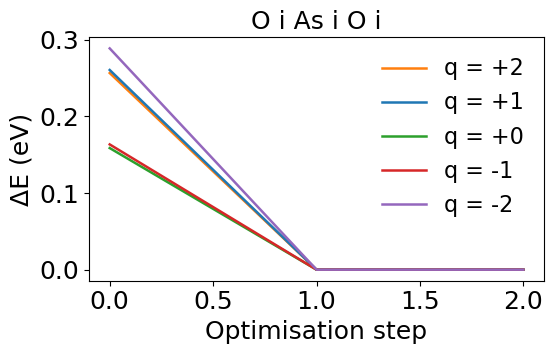

✓  Saved opt_plots/O_i_As_i_O_i.png

All selected optimisation-history plots finished.


In [7]:
# ──────────────────────────────────────────────────────────────────────────
# USER-EDITABLE SETTINGS
# ──────────────────────────────────────────────────────────────────────────
BASE_DIR      = "defects_output"  # folder containing V_Cd/, V_Te/, etc.
OUTPUT_DIR    = "opt_plots"       # where the PNGs will be written
FIG_SIZE      = (6, 4)            # inches
FONT_SIZE     = 18
DPI           = 300               # PNG resolution
BAR_ALPHA     = 0.9
# ──────────────────────────────────────────────────────────────────────────
# NO CHANGES NEEDED BELOW THIS LINE
# ──────────────────────────────────────────────────────────────────────────

from pathlib import Path
import json, re, os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family"     : "Arial Narrow",
    "axes.labelsize"  : FONT_SIZE,
    "xtick.labelsize" : FONT_SIZE,
    "ytick.labelsize" : FONT_SIZE,
})

# colour palette
CHARGE_COLS = {
    +2 : "tab:orange",
    +1 : "tab:blue",
     0 : "tab:green",
    -1 : "tab:red",
    -2 : "tab:purple",
}

def load_trajectory(json_path):
    """Return a list of energies from energy_trajectory.json."""
    try:
        with open(json_path) as f:
            data = json.load(f)
        # support list OR dict storage
        if isinstance(data, list):
            return data
        if isinstance(data, dict):
            for key in ("energy", "energies", "E", "trajectory"):
                if key in data:
                    return data[key]
    except Exception as exc:
        print(f"⚠️  Could not read {json_path}: {exc}")
    return []

# --- NEW: INTERACTIVE DEFECT SELECTION ---

base_path = Path(BASE_DIR)
if not base_path.is_dir():
    raise FileNotFoundError(f"Base directory '{BASE_DIR}' not found. Please check the path.")

# Discover available defects
available_defects = sorted([d.name for d in base_path.iterdir() if d.is_dir() and d.name != 'bulk'])

if not available_defects:
    print(f"❌ No defect subdirectories found in '{BASE_DIR}'. Exiting.")
    exit()

# Present choices to the user
print("Available defects to plot:")
print("  [0] All Defects")
for i, name in enumerate(available_defects, 1):
    print(f"  [{i}] {name}")

# Get user input
defects_to_plot = []
while True:
    try:
        choice = input("\nEnter the number of the defect to plot (or 0 for all): ")
        choice_idx = int(choice)
        if choice_idx == 0:
            defects_to_plot = available_defects
            break
        elif 1 <= choice_idx <= len(available_defects):
            defects_to_plot = [available_defects[choice_idx - 1]]
            break
        else:
            print(f"❌ Invalid number. Please enter a number between 0 and {len(available_defects)}.")
    except ValueError:
        print("❌ Invalid input. Please enter a number.")
    except (KeyboardInterrupt, EOFError):
        print("\nAborted.")
        exit()

# --- END OF INTERACTIVE PART ---

# ensure output dir exists
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"\nProcessing: {', '.join(defects_to_plot)}\n")

# ── MODIFIED: loop over SELECTED defect folders ────────────────────────
for defect_name in defects_to_plot:
    defect_dir = base_path / defect_name
    series_data = []

    # ── Collect and sort charge-state directories for a specific legend order ──
    charge_state_dirs = []
    for sub in defect_dir.iterdir():
        if not sub.is_dir():
            continue
        # Match subdirectories named "q<charge>", e.g., "q+2", "q-1", "q0"
        m = re.match(r"q([+-]?\d+)", sub.name)
        if m:
            q = int(m.group(1))
            charge_state_dirs.append((q, sub))

    # Sort by charge in descending order (+2, +1, 0, -1, -2) for plotting
    charge_state_dirs.sort(key=lambda item: item[0], reverse=True)

    # ── Load trajectory data from the sorted directories ───────────────────────
    for q, sub_dir in charge_state_dirs:
        json_path = sub_dir / "energy_trajectory.json"
        if json_path.is_file():
            colour = CHARGE_COLS.get(q, "black")
            label = f"q = {q:+d}"
            series_data.append((label, colour, load_trajectory(json_path)))

    # skip if nothing to plot
    if not series_data:
        print(f"⚠️  No trajectories found in {defect_name}")
        continue

    # ── make the optimisation-history plot ────────────────────────────
    plt.figure(figsize=FIG_SIZE)
    for label, colour, energies in series_data:
        if not energies:
            continue
        # Make initial energy relative to the final energy for better comparison
        energies_relative = np.array(energies) - energies[-1]
        steps = np.arange(len(energies_relative))
        plt.plot(steps, energies_relative, lw=1.8, color=colour, label=label)

    plt.title(defect_name.replace("_", " "), pad=6) # Replace underscore for cleaner title
    plt.xlabel("Optimisation step")
    plt.ylabel("ΔE (eV)")
    plt.legend(loc="best", frameon=False, fontsize=FONT_SIZE - 2)
    plt.tight_layout()
    plt.show()

    fname = Path(OUTPUT_DIR) / f"{defect_name}.png"
    plt.savefig(fname, dpi=DPI)
    plt.close()

    print(f"✓  Saved {fname}")

print("\nAll selected optimisation-history plots finished.")

# Run the HSE MLFF optimization

In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Defect generation + MLFF optimization (Jupyter-friendly; minimal edits)
# ─────────────────────────────────────────────────────────────────────────────

import sys, json, requests
from pathlib import Path
from itertools import product

import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings

from pymatgen.core import Structure
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter

from matgl import load_model
from matgl.ext.ase import Relaxer

warnings.filterwarnings("ignore", category=FutureWarning, module="matgl.ext.ase")

# -----------------------------------------------------------------------------
# CONFIG (adds p1, p2; uses user home for IO)
# -----------------------------------------------------------------------------
RAW_BASE = "https://raw.githubusercontent.com/msehabibur/nanohub-simple-jupyter-tool/main/data/PES_HSE"
CANDIDATE_FILES = [
    "model.json", "model.pt", "state.pt", "config.json", "pytorch_model.bin", "weights.pt",
]
# Include +1 and +2
CHARGE_DIRS = {0: "hse_neutral", +1: "hse_p1", +2: "hse_p2", -1: "hse_m1", -2: "hse_m2"}

# Always read user uploads from home directory
BULK_FILE = str(Path.home() / "nanohub_uploads" / "POSCAR.vasp")
DEFECTS_FILE = str(Path.home() / "nanohub_uploads" / "Defects.txt")

FMAX = 1e-5
STEPS = 1
OUTDIR = Path.home() / "defects_output"
# -----------------------------------------------------------------------------


# -----------------------------------------------------------------------------
# Model download + load (kept logic; supports neutral special-case + p1/p2/m1/m2)
# -----------------------------------------------------------------------------
def download_model_dir(model_name: str, dest_root: str = "models") -> Path:
    """
    Downloads model files into ~/models/<model_name>.
    Special-case for 'hse_neutral' flat layout; others are in subdirs.
    """
    dest_root_path = Path.home() / dest_root
    local_dir = dest_root_path / model_name
    local_dir.mkdir(parents=True, exist_ok=True)

    if model_name == "hse_neutral":
        # Map repo filenames -> local standard names
        source_files = {
            "model.json": "hse_neutral.json",
            "model.pt":   "hse_neutral.pt",
            "state.pt":   "hse_neutral.pth",  # if present
        }
        for local_name, remote_name in source_files.items():
            url = f"{RAW_BASE}/{remote_name}"
            dst = local_dir / local_name
            if dst.exists():
                continue
            try:
                r = requests.get(url, timeout=60)
                if r.status_code == 200 and r.content:
                    dst.write_bytes(r.content)
                    print(f"⬇️  {model_name}: {remote_name} -> {dst.name}")
            except Exception:
                pass
    else:
        # Standard subdirectory fetch for pbe_p1, pbe_p2, pbe_m1, pbe_m2
        for fn in CANDIDATE_FILES:
            url = f"{RAW_BASE}/{model_name}/{fn}"
            dst = local_dir / fn
            if dst.exists():
                continue
            try:
                r = requests.get(url, timeout=60)
                if r.status_code == 200 and r.content:
                    dst.write_bytes(r.content)
                    print(f"⬇️  {model_name}: {fn}")
            except Exception:
                pass

    # Require at least one core file
    if not any((local_dir / fn).exists() for fn in ["model.json", "model.pt", "state.pt"]):
        raise FileNotFoundError(
            f"No usable model files found in {local_dir} after download attempt.\n"
            f"Please check {RAW_BASE}/ for folder '{model_name}'."
        )
    return local_dir

def load_relaxer_from_repo(model_name: str, relax_cell: bool) -> Relaxer:
    mdir = download_model_dir(model_name)
    model = load_model(str(mdir))
    return Relaxer(model, relax_cell=relax_cell, optimizer="FIRE")

# -----------------------------------------------------------------------------
# Structure + Defect builders (A_B means “A on B site”; V_X and X_i unchanged)
# -----------------------------------------------------------------------------
def read_structure(p: Path) -> Structure:
    p = Path(p)
    ext = p.suffix.lower()
    if ext in (".cif", ".vasp") or p.name.upper() in ("POSCAR", "CONTCAR"):
        return Structure.from_file(p)
    if ext == ".xsf":
        try:
            from ase.io import read, write
            tmp = p.with_suffix(".cif")
            write(str(tmp), read(p))
            s = Structure.from_file(tmp)
            tmp.unlink(missing_ok=True)
            return s
        except Exception as e:
            raise RuntimeError(f"XSF conversion failed; install ase. Original error: {e}")
    return Structure.from_file(p)

def get_central_atom_idx(struct: Structure, symbol: str, excluded_indices: list = None) -> int:
    if excluded_indices is None:
        excluded_indices = []
    center = struct.lattice.get_cartesian_coords([0.5, 0.5, 0.5])
    min_dist, best_idx = float("inf"), -1
    for i, site in enumerate(struct):
        if i in excluded_indices or site.specie.symbol != symbol:
            continue
        d = np.linalg.norm(site.coords - center)
        if d < min_dist:
            min_dist, best_idx = d, i
    if best_idx < 0:
        raise ValueError(f"No available atom '{symbol}' found near the center (already used or does not exist).")
    return best_idx

def get_min_pbc_distance(struct: Structure, cart_coords: np.ndarray) -> float:
    frac = struct.lattice.get_fractional_coords(cart_coords)
    mind = float("inf")
    for site in struct:
        df = frac - site.frac_coords
        df -= np.round(df)
        d = np.linalg.norm(struct.lattice.get_cartesian_coords(df))
        if d < mind:
            mind = d
    return float(mind)

def add_interstitial(struct: Structure, symbol: str):
    best_pos, best_d = None, -1.0
    for f in product(np.linspace(0.3, 0.7, 7), repeat=3):
        cart = struct.lattice.get_cartesian_coords(f)
        d = get_min_pbc_distance(struct, cart)
        if d > best_d:
            best_d, best_pos = d, cart
    if best_pos is None:
        raise ValueError(f"Could not place interstitial {symbol}.")
    struct.append(symbol, best_pos, coords_are_cartesian=True)

def create_defect_structure(bulk: Structure, defect_str: str) -> Structure:
    """
    Build a defect from tokens like:
      - V_Cd           (vacancy on Cd site)
      - O_i            (O interstitial)
      - As_Te          (As substituting on Te site)  [A_B = A on B]
      - Cu_i+Cu_i      (multiple tokens with '+')
    """
    s = bulk.copy()
    used_indices = []
    species_in_struct = sorted({site.specie.symbol for site in s})

    for raw in defect_str.split('+'):
        part = raw.strip()
        if not part:
            continue

        # Vacancy: V_X  -> remove an X atom near center (unused)
        if part.startswith("V_"):
            host = part[2:]
            if host not in species_in_struct:
                raise ValueError(
                    f"Vacancy target '{host}' not found in structure. "
                    f"Available species: {species_in_struct}"
                )
            idx = get_central_atom_idx(s, host, excluded_indices=used_indices)
            s.remove_sites([idx])
            used_indices.append(idx)
            continue

        # Interstitial: X_i -> add X at low-overlap position
        if part.endswith("_i"):
            elem = part[:-2]
            if not elem or not elem[0].isalpha():
                raise ValueError(f"Invalid interstitial token: '{part}'")
            add_interstitial(s, elem)
            continue

        # Substitution: A_B -> put A on B site (replace B with A)
        if "_" in part:
            A, B = part.split("_", 1)
            if B not in species_in_struct:
                raise ValueError(
                    f"Substitution site '{B}' not found in structure for token '{part}'. "
                    f"Available species: {species_in_struct}"
                )
            idx = get_central_atom_idx(s, B, excluded_indices=used_indices)
            s.replace(idx, A)
            used_indices.append(idx)
            continue

        raise ValueError(f"Unknown defect token: '{part}'")

    return s

# -----------------------------------------------------------------------------
# Core workflow (unchanged; only model loading tolerant for missing models)
# -----------------------------------------------------------------------------
def run_defect_mlff(
    bulk_file: str = BULK_FILE,
    defects_file: str = DEFECTS_FILE,
    fmax: float = FMAX,
    steps: int = STEPS,
    outdir: Path = OUTDIR
):
    out_dir = Path(outdir)
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"✅ Output will be saved to: {out_dir.resolve()}")

    bulk_path = Path(bulk_file)
    defect_path = Path(defects_file)

    if not bulk_path.is_file():
        raise FileNotFoundError(f"Bulk file not found: {bulk_path}")
    if not defect_path.is_file():
        raise FileNotFoundError(f"Defects file not found: {defect_path}")

    print("📄 Reading bulk structure…")
    bulk_initial = read_structure(bulk_path)

    print("🔃 Preparing MatGL models (cached in your home: ~/models/)")
    relaxers = {}
    for q, name in CHARGE_DIRS.items():
        try:
            # bulk (q=0) gets relax_cell=True; defects set to False later
            relaxers[q] = load_relaxer_from_repo(name, relax_cell=(q == 0))
        except Exception as e:
            print(f"⚠️  Skipping model '{name}' for q={q:+d}: {e}")

    if 0 not in relaxers:
        raise RuntimeError("No neutral model available (q=0). Cannot relax bulk structure.")

    bulk_relaxer = relaxers[0]
    print("✅ Models loaded (available charges):", sorted(relaxers.keys()))

    print("🔧 Relaxing bulk…")
    bulk_res = bulk_relaxer.relax(bulk_initial.copy(), fmax=fmax, steps=steps)
    bulk_opt = bulk_res["final_structure"]
    E_bulk = float(bulk_res["trajectory"].energies[-1])
    print(f"   ↳ Bulk energy: {E_bulk:.6f} eV")

    (out_dir / "bulk").mkdir(parents=True, exist_ok=True)
    Poscar(bulk_opt).write_file(out_dir / "bulk" / "POSCAR_opt")
    CifWriter(bulk_opt).write_file(out_dir / "bulk" / "bulk_opt.cif")
    with open(out_dir / "bulk" / "energy_trajectory.json", "w") as f:
        json.dump([float(e) for e in bulk_res["trajectory"].energies], f, indent=2)

    defects = [ln.strip() for ln in defect_path.read_text().splitlines()
               if ln.strip() and not ln.strip().startswith("#")]
    print(f"🧪 Processing {len(defects)} defects…")

    rows = []
    for dstr in tqdm(defects, desc="Defects"):
        tag = dstr.replace("+", "_")
        row = {"Defect": dstr, "E_bulk": E_bulk}

        try:
            sdef = create_defect_structure(bulk_opt, dstr)
            sdef.perturb(0.01)
        except Exception as e:
            print(f"   ↳ ERROR building {dstr}: {e}")
            row["Error"] = f"build: {e}"
            rows.append(row)
            continue

        for q, relaxer in sorted(relaxers.items()):
            # Do not relax the cell for defects
            relaxer.relax_cell = False
            qdir = out_dir / tag / f"q{q:+d}"
            qdir.mkdir(parents=True, exist_ok=True)
            try:
                res = relaxer.relax(sdef.copy(), fmax=fmax, steps=steps)
                E_final = float(res["trajectory"].energies[-1])
                print(f"   ↳ Optimized {dstr} (q={q:+d}): {E_final:.6f} eV")
                row[f"E({q:+d})"] = E_final
                CifWriter(res["final_structure"]).write_file(qdir / f"{tag}_q{q:+d}_opt.cif")
                with open(qdir / "energy_trajectory.json", "w") as f:
                    json.dump([float(e) for e in res["trajectory"].energies], f, indent=2)
            except Exception as e:
                row[f"E({q:+d})"] = "error"
                print(f"   ↳ ERROR optimizing {dstr} (q={q:+d}): {e}")

        rows.append(row)

    df = pd.DataFrame(rows)
    out_csv = out_dir / "optimisation_results.csv"
    df.to_csv(out_csv, index=False, float_format="%.6f")
    print(f"\n✅ Done. Outputs are in: {out_dir.resolve()}")
    print("   - bulk/POSCAR_opt, bulk_opt.cif, energy_trajectory.json")
    print("   - <defect>/q±*/ (CIFs + energy trajectories)")
    print(f"   - {out_csv.name}")

# -----------------------------------------------------------------------------
# Run inline in Jupyter (no changes besides paths/config above)
# -----------------------------------------------------------------------------
run_defect_mlff(
    bulk_file=BULK_FILE,
    defects_file=DEFECTS_FILE,
    fmax=FMAX,
    steps=STEPS,
    outdir=OUTDIR,
)


✅ Output will be saved to: /home/nanohub/rahma103/defects_output
📄 Reading bulk structure…
🔃 Preparing MatGL models (cached in your home: ~/models/)
✅ Models loaded (available charges): [-2, -1, 0, 1, 2]
🔧 Relaxing bulk…
   ↳ Bulk energy: -684.786316 eV
🧪 Processing 1 defects…


Defects:   0%|          | 0/1 [00:00<?, ?it/s]

   ↳ Optimized O_i+As_i+O_i (q=-2): -683.726685 eV
   ↳ Optimized O_i+As_i+O_i (q=-1): -696.393921 eV
   ↳ Optimized O_i+As_i+O_i (q=+0): -696.728943 eV
   ↳ Optimized O_i+As_i+O_i (q=+1): -702.799561 eV


Defects: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]

   ↳ Optimized O_i+As_i+O_i (q=+2): -700.891846 eV

✅ Done. Outputs are in: /home/nanohub/rahma103/defects_output
   - bulk/POSCAR_opt, bulk_opt.cif, energy_trajectory.json
   - <defect>/q±*/ (CIFs + energy trajectories)
   - optimisation_results.csv


# Visualize the HSE energy landscape

Available defects to plot:
  [0] All Defects
  [1] Cu_i_Cu_i
  [2] O_i_As_i_O_i
  [3] V_Cd

Enter the number of the defect to plot (or 0 for all): 2


findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.



Processing: O_i_As_i_O_i



findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not found.
findfont: Font family 'Arial Narrow' not

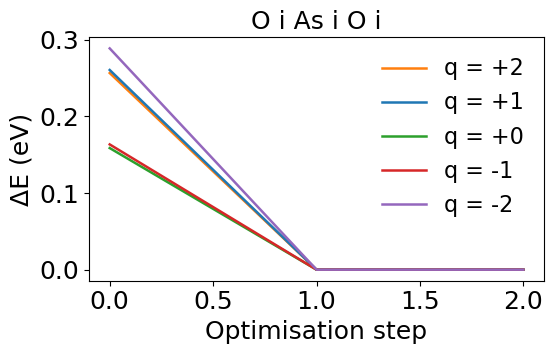

✓  Saved opt_plots/O_i_As_i_O_i.png

All selected optimisation-history plots finished.


In [9]:
# ──────────────────────────────────────────────────────────────────────────
# USER-EDITABLE SETTINGS
# ──────────────────────────────────────────────────────────────────────────
BASE_DIR      = "defects_output"  # folder containing V_Cd/, V_Te/, etc.
OUTPUT_DIR    = "opt_plots"       # where the PNGs will be written
FIG_SIZE      = (6, 4)            # inches
FONT_SIZE     = 18
DPI           = 300               # PNG resolution
BAR_ALPHA     = 0.9
# ──────────────────────────────────────────────────────────────────────────
# NO CHANGES NEEDED BELOW THIS LINE
# ──────────────────────────────────────────────────────────────────────────

from pathlib import Path
import json, re, os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family"     : "Arial Narrow",
    "axes.labelsize"  : FONT_SIZE,
    "xtick.labelsize" : FONT_SIZE,
    "ytick.labelsize" : FONT_SIZE,
})

# colour palette
CHARGE_COLS = {
    +2 : "tab:orange",
    +1 : "tab:blue",
     0 : "tab:green",
    -1 : "tab:red",
    -2 : "tab:purple",
}

def load_trajectory(json_path):
    """Return a list of energies from energy_trajectory.json."""
    try:
        with open(json_path) as f:
            data = json.load(f)
        # support list OR dict storage
        if isinstance(data, list):
            return data
        if isinstance(data, dict):
            for key in ("energy", "energies", "E", "trajectory"):
                if key in data:
                    return data[key]
    except Exception as exc:
        print(f"⚠️  Could not read {json_path}: {exc}")
    return []

# --- NEW: INTERACTIVE DEFECT SELECTION ---

base_path = Path(BASE_DIR)
if not base_path.is_dir():
    raise FileNotFoundError(f"Base directory '{BASE_DIR}' not found. Please check the path.")

# Discover available defects
available_defects = sorted([d.name for d in base_path.iterdir() if d.is_dir() and d.name != 'bulk'])

if not available_defects:
    print(f"❌ No defect subdirectories found in '{BASE_DIR}'. Exiting.")
    exit()

# Present choices to the user
print("Available defects to plot:")
print("  [0] All Defects")
for i, name in enumerate(available_defects, 1):
    print(f"  [{i}] {name}")

# Get user input
defects_to_plot = []
while True:
    try:
        choice = input("\nEnter the number of the defect to plot (or 0 for all): ")
        choice_idx = int(choice)
        if choice_idx == 0:
            defects_to_plot = available_defects
            break
        elif 1 <= choice_idx <= len(available_defects):
            defects_to_plot = [available_defects[choice_idx - 1]]
            break
        else:
            print(f"❌ Invalid number. Please enter a number between 0 and {len(available_defects)}.")
    except ValueError:
        print("❌ Invalid input. Please enter a number.")
    except (KeyboardInterrupt, EOFError):
        print("\nAborted.")
        exit()

# --- END OF INTERACTIVE PART ---

# ensure output dir exists
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"\nProcessing: {', '.join(defects_to_plot)}\n")

# ── MODIFIED: loop over SELECTED defect folders ────────────────────────
for defect_name in defects_to_plot:
    defect_dir = base_path / defect_name
    series_data = []

    # ── Collect and sort charge-state directories for a specific legend order ──
    charge_state_dirs = []
    for sub in defect_dir.iterdir():
        if not sub.is_dir():
            continue
        # Match subdirectories named "q<charge>", e.g., "q+2", "q-1", "q0"
        m = re.match(r"q([+-]?\d+)", sub.name)
        if m:
            q = int(m.group(1))
            charge_state_dirs.append((q, sub))

    # Sort by charge in descending order (+2, +1, 0, -1, -2) for plotting
    charge_state_dirs.sort(key=lambda item: item[0], reverse=True)

    # ── Load trajectory data from the sorted directories ───────────────────────
    for q, sub_dir in charge_state_dirs:
        json_path = sub_dir / "energy_trajectory.json"
        if json_path.is_file():
            colour = CHARGE_COLS.get(q, "black")
            label = f"q = {q:+d}"
            series_data.append((label, colour, load_trajectory(json_path)))

    # skip if nothing to plot
    if not series_data:
        print(f"⚠️  No trajectories found in {defect_name}")
        continue

    # ── make the optimisation-history plot ────────────────────────────
    plt.figure(figsize=FIG_SIZE)
    for label, colour, energies in series_data:
        if not energies:
            continue
        # Make initial energy relative to the final energy for better comparison
        energies_relative = np.array(energies) - energies[-1]
        steps = np.arange(len(energies_relative))
        plt.plot(steps, energies_relative, lw=1.8, color=colour, label=label)

    plt.title(defect_name.replace("_", " "), pad=6) # Replace underscore for cleaner title
    plt.xlabel("Optimisation step")
    plt.ylabel("ΔE (eV)")
    plt.legend(loc="best", frameon=False, fontsize=FONT_SIZE - 2)
    plt.tight_layout()
    plt.show()

    fname = Path(OUTPUT_DIR) / f"{defect_name}.png"
    plt.savefig(fname, dpi=DPI)
    plt.close()

    print(f"✓  Saved {fname}")

print("\nAll selected optimisation-history plots finished.")

# Compute Chemical Potential Limit (reference energy)

In [ ]:
# If needed in this env:
# !pip install --user doped pymatgen monty requests

from pathlib import Path
import io, tarfile, zipfile, requests, warnings, inspect
import numpy as np
import pandas as pd
from doped.chemical_potentials import CompetingPhasesAnalyzer
from pymatgen.io.vasp import Vasprun
from pymatgen.core.composition import Composition

# =======================
# Interactive inputs
# =======================
compound = input("Compound formula (e.g. CdTe): ").strip()
if not compound:
    raise ValueError("Compound formula cannot be empty.")
ans = input("Consider impurities? (y/n): ").strip().lower()
if ans == "y":
    raw = input("Impurity element(s) (comma-separated, e.g. Cl,O): ").strip()
    impurities = [x.strip() for x in raw.split(",") if x.strip()]
else:
    impurities = []

# =======================
# CONFIG
# =======================
FORMULA    = compound
IMPURITIES = impurities

REPO = "msehabibur/nanohub-simple-jupyter-tool"
TAG  = "CompetingPhases"

BASE_DIR    = Path.cwd() / "CompetingPhases_local"
ASSETS_DIR  = BASE_DIR / "assets"
EXTRACT_DIR = BASE_DIR / "extracted"
ASSETS_DIR.mkdir(parents=True, exist_ok=True)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

CHEMPOT_CSV   = f"{FORMULA}_chempots.csv"
DEFECT_MU_CSV = "defect_mu_table.csv"

# =======================
# Quiet noisy warnings
# =======================
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0")
np.seterr(divide="ignore", invalid="ignore")

# =======================
# Helpers
# =======================
def download_release_assets(repo: str, tag: str, assets_dir: Path, extract_dir: Path):
    api = f"https://api.github.com/repos/{repo}/releases/tags/{tag}"
    print(f"🔎 Fetching GitHub release: {repo}@{tag}")
    r = requests.get(api, timeout=60)
    r.raise_for_status()
    assets = r.json().get("assets", [])
    if not assets:
        raise RuntimeError("No assets found on the release. Check repo/tag.")

    for a in assets:
        name = a.get("name", "download.bin")
        url  = a.get("browser_download_url")
        if not url:
            print(f"⚠️  Skipping asset without URL: {name}")
            continue

        out = assets_dir / name
        if out.exists():
            print(f"📦 Using cached asset: {out.name}")
            data = out.read_bytes()
        else:
            print(f"⬇️  Downloading: {name}")
            resp = requests.get(url, timeout=300)
            resp.raise_for_status()
            data = resp.content
            out.write_bytes(data)

        # Try to extract as ZIP or TAR.*; otherwise, save as-is
        buf = io.BytesIO(data)
        extracted = None
        try:
            if zipfile.is_zipfile(buf):
                buf.seek(0)
                root = extract_dir / name.rsplit(".", 1)[0]
                root.mkdir(exist_ok=True)
                with zipfile.ZipFile(buf) as zf:
                    zf.extractall(root)
                extracted = root
                print(f"📂 Extracted ZIP → {root}")
            else:
                buf.seek(0)
                try:
                    with tarfile.open(fileobj=buf, mode="r:*") as tf:
                        root = extract_dir / name.rsplit(".", 1)[0]
                        root.mkdir(exist_ok=True)
                        tf.extractall(root)
                        extracted = root
                        print(f"📂 Extracted TAR → {root}")
                except tarfile.TarError:
                    pass
        except Exception as e:
            print(f"⚠️  Extraction failed for {name}: {e}")

        if extracted is None:
            target = extract_dir / name
            if not target.exists():
                target.write_bytes(data)
            print(f"📄 Saved non-archive asset to {target}")

def find_vasprun_xml(base: Path) -> list[str]:
    paths = sorted({str(p.resolve()) for p in base.rglob("vasprun.xml") if p.is_file()})
    print(f"✅ Found {len(paths)} vasprun.xml files under {base}")
    return paths

def _vasprun_version_compatible(path: str) -> Vasprun:
    """Create Vasprun with only kwargs supported by the installed pymatgen."""
    candidate_kwargs = dict(
        parse_dos=False,
        parse_eigen=False,
        parse_projected_eigen=False,
        # parse_projected_dos=False,  # not present in many versions
        parse_potcar=False,
        exception_on_bad_xml=False,
        ionic_step_skip=999999,  # dropped if unsupported
    )
    sig = inspect.signature(Vasprun.__init__)
    supported = {k: v for k, v in candidate_kwargs.items() if k in sig.parameters}
    return Vasprun(path, **supported)

def filter_vaspruns_subset(vasprun_paths, formula="CdTe"):
    """
    Keep vaspruns that:
      (a) parse successfully,
      (b) have finite final energy,
      (c) use only elements drawn from the target chemical system (subset check).
         e.g., for CdTe → allow {Cd}, {Te}, {Cd,Te}
    """
    elems_system = set(Composition(formula).elements)
    keep, drop = [], []
    for p in vasprun_paths:
        try:
            vr = _vasprun_version_compatible(p)
            E = float(vr.final_energy)
            comp_elems = set(vr.final_structure.composition.elements)
            if np.isfinite(E) and comp_elems.issubset(elems_system) and len(comp_elems) > 0:
                keep.append(p)
            else:
                drop.append((p, "non-finite energy or outside chemsys"))
        except Exception as e:
            drop.append((p, f"parse error: {e}"))
    if drop:
        print(f"⚠️  Dropping {len(drop)} vaspruns. First few:")
        for p, why in drop[:5]:
            print(f"   - {p} [{why}]")
    print(f"✅ Keeping {len(keep)} vaspruns")
    return keep

def find_element_vasprun(element: str, base: Path) -> str | None:
    """Find a vasprun.xml corresponding to the elemental phase of `element`."""
    # Prefer folder paths like .../<Element>/vasprun.xml
    candidates = list((base.rglob(f"{element}/vasprun.xml")))
    if candidates:
        return str(candidates[0].resolve())
    # Fallback: pick a vasprun whose final structure is mono-elemental
    for p in base.rglob("vasprun.xml"):
        try:
            vr = _vasprun_version_compatible(str(p))
            elems = set(vr.final_structure.composition.elements)
            if elems == {Composition(element).elements[0]}:
                return str(p.resolve())
        except Exception:
            pass
    return None

def ref_energy_per_atom(path: str) -> float:
    vr = _vasprun_version_compatible(path)
    return float(vr.final_energy) / float(vr.final_structure.num_sites)

# =======================
# Phase parsing + chempots
# =======================
download_release_assets(REPO, TAG, ASSETS_DIR, EXTRACT_DIR)
vaspruns_all = find_vasprun_xml(EXTRACT_DIR)
if not vaspruns_all:
    raise RuntimeError("No vasprun.xml files found in extracted contents.")

vaspruns = filter_vaspruns_subset(vaspruns_all, formula=FORMULA)
if not vaspruns:
    raise RuntimeError("All vaspruns were filtered out; nothing to analyze.")

print(f"🧪 Running CompetingPhasesAnalyzer for {FORMULA} on {len(vaspruns)} files…")
cpa = CompetingPhasesAnalyzer(FORMULA, vaspruns)
chempot_df = cpa.calculate_chempots()

# Display & save Δμ table
print("\nCalculated chemical potential limits (in eV wrt elemental reference phases): \n")
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(chempot_df)
chempot_df.to_csv(CHEMPOT_CSV, index=False)
print(f"📄 Saved chemical-potential table to {CHEMPOT_CSV}")

# =======================
# Build defect μ table (wide)  — FIXED 'Limit' handling
# =======================
print("\n" + "═"*62)
print("⛏️  Building defect μ table (wide) using elemental references")
print("═"*62)

# Normalize: ensure 'Limit' is a COLUMN (not index)
mu_df = chempot_df.copy()
if 'Limit' not in mu_df.columns:
    # If 'Limit' is the index name, move it to a column
    mu_df = mu_df.reset_index()
    if 'index' in mu_df.columns and 'Limit' not in mu_df.columns:
        mu_df = mu_df.rename(columns={'index': 'Limit'})
# Ensure 'Limit' is string
if 'Limit' in mu_df.columns:
    mu_df['Limit'] = mu_df['Limit'].astype(str)

# Elements of host compound + impurities
host_elements = [str(el) for el in Composition(FORMULA).elements]
all_elements  = host_elements + list(IMPURITIES)

# Locate elemental reference vaspruns and compute E_ref per atom
E_ref_dict = {}
missing_refs = []
for el in all_elements:
    p = find_element_vasprun(el, EXTRACT_DIR)
    if p is None:
        missing_refs.append(el)
        continue
    try:
        E_ref_dict[el] = ref_energy_per_atom(p)
    except Exception:
        missing_refs.append(el)

if E_ref_dict:
    print("\nReference energies (eV/atom):")
    for el, E in E_ref_dict.items():
        print(f"  E_ref({el}) = {E:.6f}")
if missing_refs:
    print(f"\n⚠️  Missing elemental references for: {missing_refs}")

# Add absolute μ_i = Δμ_i + E_ref(i), if Δμ column exists
for el in all_elements:
    if el in mu_df.columns and el in E_ref_dict:
        mu_df[f"mu_{el} (eV)"] = mu_df[el] + E_ref_dict[el]

# Enumerate defects
defect_list = []
# native
for el in host_elements:
    defect_list.append(f"V_{el}")
for i, el1 in enumerate(host_elements):
    for j, el2 in enumerate(host_elements):
        if i != j:
            defect_list.append(f"{el1}_{el2}")
for el in host_elements:
    defect_list.append(f"{el}_i")
# impurities
for imp in IMPURITIES:
    defect_list.append(f"{imp}_i")
    for host in host_elements:
        defect_list.append(f"{imp}_{host}")

defect_list = sorted(set(defect_list))
print(f"\nDefect list ({len(defect_list)}): {defect_list}")

# Build long table with robust condition naming
rows = []
for i, row in mu_df.iterrows():
    if 'Limit' in mu_df.columns and pd.notna(row.get('Limit', None)) and str(row['Limit']).strip():
        cond = str(row['Limit']).strip()
    else:
        cond = f"Condition_{i+1}"  # i is always an integer counter here
    for d in defect_list:
        parts = d.split("_")
        if d.startswith("V_"):
            el  = parts[1]
            mu  = row.get(f"mu_{el} (eV)", np.nan)
        elif d.endswith("_i"):
            el  = parts[0]
            mu0 = row.get(f"mu_{el} (eV)", np.nan)
            mu  = (-mu0) if (pd.notna(mu0)) else np.nan
        else:
            src, dst = parts  # X_Y : μ(Y) − μ(X)
            mu_src = row.get(f"mu_{src} (eV)", np.nan)
            mu_dst = row.get(f"mu_{dst} (eV)", np.nan)
            mu     = (mu_dst - mu_src) if (pd.notna(mu_dst) and pd.notna(mu_src)) else np.nan
        rows.append({"Condition": cond, "Defect": d, "mu_eV": mu})

long_df = pd.DataFrame(rows)

print("\nPivoting table to wide format…")
wide_df = long_df.pivot(index="Defect", columns="Condition", values="mu_eV").reset_index()
wide_df.columns.name = None

wide_df.to_csv(DEFECT_MU_CSV, index=False, float_format="%.4f")
print(f"\n📄 {DEFECT_MU_CSV} written.")
with pd.option_context("display.float_format", "{:.2f}".format):
    display(wide_df.head())